In [5]:
#imports go here

from sage.plot.polygon import Polygon
from sage.plot.colors import rainbow

In [6]:
"""
There are two problems we want to solve:
1) How large of a supertile must we compute to find all of the 1-collared prototiles?
2) How can we generate all of the 1-collared prototiles from a large enough subsection of the tiling?

Also, we want to be able to do this for other types of tilings, not just those that use vertical/horizontal
lines to construct the prototiles. For instance, https://tilings.math.uni-bielefeld.de/substitution/binary/
uses rhombuses with internal angles either in {pi/5, 3pi/5} or {2pi/5, 4pi/5}

For now, the focus will be on representing tilings as a collection of objects rather than as a graphics
object, as this will save computing power and the resulting collections can just be graphed after being
generated. Once we can generate large supertile objects, we can start to write functions that generate
the possible collars of a set of prototiles.
"""

# This lets us not have to create a new matrix object every time we need to do a rotation.
# Just index into the dictionary with the angle you need to rotate by.

rot = {
    0 : matrix(2,2,[cos(0),-sin(0),sin(0),cos(0)]),
    pi/2 : matrix(2,2,[cos(pi/2),-sin(pi/2),sin(pi/2),cos(pi/2)]),
    pi: matrix(2,2,[cos(pi),-sin(pi),sin(pi),cos(pi)]),
    3*pi/2 : matrix(2,2,[cos(3*pi/2),-sin(3*pi/2),sin(3*pi/2),cos(3*pi/2)])
}

# Calculates theta mod 2pi, assuming theta is in the range [0, 4pi)
def mod_2pi (theta):
    if theta >= 2*pi:
        return theta - 2*pi
    return theta

# We keep a dictionary for the supertile, where each key-value pair is given as:
# {point : prototiles}
# where point is a vertex of some prototile in the supertile and prototiles is
# a list of the tiles which share that vertex. This will make it easier to search
# for prototiles given a vertex, since lookup in a dictionary is constant-time and
# the list of prototiles will only be of size 4, at most.
vert_map = {}

class ChairTile:
    
    # We define a supertile by:
    # level, i.e. n where the supertile is L_n
    # orientation as a multiple of pi describing rotation around its center
    # origin, describing where to place this tile when moving up a level. The origin is the point that stays fixed
    #     when moving up a level.    
    def __init__(self, level: int, orientation, origin: vector, parent):
        self.points = []
        self.level = level
        self.orientation = mod_2pi(orientation)
        self.origin = origin
        self.id = 0
        self.adj = None
        self.vert_map = None
        self.prototile_ids = None

        # Track the supertile containing this tile. This way, we can keep an adjacency matrix
        # or a vert_map as a class variable, but still have the subtiles refer to the matrix/map
        # of the largest supertile. 
        if parent == None:
            self.parent = self
            self.vert_map = {}
            self.prototile_ids = [None for i in range(4 ** level)]
            self.adj = [[0 for i in range(4 ** level)] for j in range(4 ** level)]
        else:
            self.parent = parent
        

        if (level < 0):
            raise Exception("Level must be a non-negative integer.")

        #TODO: Add 2 extra vertices for between the long ends, to make it clearer
        if (level == 0):
            # The adjacency matrix which represents the bordering prototiles of a prototile. 
            # adj[self.id][other.id] has a 1 if self borders other, and 0 otherwise. Note
            # only prototiles have an id.
            # self.adj = [[0] * 4**self.parent.level] * 4**self.parent.level

            if self.parent.level != 0:
                self.id = self.parent.id
                self.parent.id += 1
                self.parent.prototile_ids[self.id] = self
            
            self.points = [vector((0 + origin[0], 0 + origin[1])),
                           vector((1 + origin[0], 0 + origin[1])),
                           vector((2 + origin[0], 0 + origin[1])), 
                           vector((2 + origin[0], 1 + origin[1])), 
                           vector((1 + origin[0], 1 + origin[1])), 
                           vector((1 + origin[0], 2 + origin[1])), 
                           vector((0 + origin[0], 2 + origin[1])),
                           vector((0 + origin[0], 1 + origin[1]))]
            self.rotate_tile(origin, rot[self.orientation])

            for p in self.points:
                l = tuple(p)
                if self.parent.vert_map.get(l):
                    self.parent.vert_map[l].append(self)
                else:
                    self.parent.vert_map[l] = [self]

        else:
            # If this is a supertile, we consider it to be the collection of all the prototiles that make it up
            self.subtiles = list()
            st_1 = ChairTile(level - 1, self.orientation, origin, self.parent)
            st_2 = ChairTile(level - 1, self.orientation, origin + rot[self.orientation]*vector((2**(level - 1), 2**(level - 1))), self.parent)
            st_3 = ChairTile(level - 1, self.orientation + pi/2, origin + rot[self.orientation]*vector((2** (level + 1), 0)), self.parent)
            st_4 = ChairTile(level - 1, self.orientation + 3*pi/2, origin + rot[self.orientation]*vector((0, 2** (level + 1))), self.parent)
            
            self.subtiles.append(st_1)
            self.subtiles.append(st_2)
            self.subtiles.append(st_3)
            self.subtiles.append(st_4)        

    # Rotates a tile around a point, where mat is the rotation matrix for the degree of rotation
    def rotate_tile(self, center, mat):
        if self.level == 0:
            pts = [mat*vector((p[0]-center[0],p[1]-center[1])) for p in self.points]
            self.points = [(p[0]+center[0],p[1]+center[1]) for p in pts]
        else:
            for c in self.subtiles:
                c.rotate_tile(center, mat)

    # Display a tile, graphically. Useful for bug-fixing and testing.
    def show_tile(self):
        show(polygon(self.points, fill=false, xmin=0, ymin=0, xmax=32, ymax=32))

    
    # Builds the adjacency matrix
    def build_adj_matrix (self):
        for pt in self.vert_map:
            tiles = self.vert_map[pt]
            for i in range(len(tiles)):
                for j in range(i, len(tiles)):
                    self.adj[tiles[i].id][tiles[j].id] = self.adj[tiles[j].id][tiles[i].id] = 1


    # Finds the border between the level n-1 supertiles within this tile by examining the adjacency matrix
    # while ignoring the tiles which don't have a k-collar (i.e. those which have the outside of the supertile
    # within their k-neighborhood)
    def find_border_matrix(self, k_neighborhood):
        if self.adj == None:
            raise Exception("Adjacency matrix must be built first")
        
        self.border_tiles = set()
        for i in range(1,4):
            # We want to break up the matrix into 16 squares, and mark tiles a,b as border tiles if 
            # adj[a.id][b.id] = 1 and adj[a.id][b.id] is in one of the six bottom-left squares
            for j in range(i):
                # Search the square of size 4**(level-1) which is at (i,j) in the matrix
                for k in range(i * 4**(self.level-1), (i+1) * 4**(self.level-1)):
                    for l in range(j * 4**(self.level-1), (j+1) * 4**(self.level-1)):
                        if self.adj[k][l] == 1:
                            self.border_tiles.add(self.prototile_ids[k])
                            self.border_tiles.add(self.prototile_ids[l])

        # We want to remove tiles which have the outside of the supertile within their k-neighborhood. We can do this by first
        # finding the tiles which are directly connected to the supertile boundary, and then find which prototiles have any of those
        # within their (k-1)-neighborhoods. We find the first set by iterating over each tile's edges and finding those edges which
        # only border one prototile. The next set is found by the adjacency matrix. 
        tiles_to_remove = set()
        
        for tile in self.border_tiles:
            for i in range(len(tile.points)):
                # Two points which are on an edge are always 'next to' each other in the points list.
                if len(set(self.vert_map[tile.points[i]]) & set(self.vert_map[tile.points[(i + 1) % len(tile.points)]])) == 1:
                    tiles_to_remove.add(tile)

        # Remove the (k-1)-neighbors of the tiles we found
        if k_neighborhood >= 1:
            #TODO: find (k-1)-neighbors of every boundary tile, THEN remove things close to the edge
            
            matrix_k = (Matrix(self.adj))^(k_neighborhood-1)
            neighborhoods_to_remove = set()
            for t in self.border_tiles - tiles_to_remove:
                for b in tiles_to_remove:
                    if matrix_k[b.id,t.id] >= 1:
                        neighborhoods_to_remove.add(t)

            tiles_to_remove = tiles_to_remove.union(neighborhoods_to_remove)

        

        self.border_tiles = self.border_tiles - tiles_to_remove

In [7]:
# Displays a supertile s graphically
def display_tiles(s, color = (0,0,1), do_fill=false):
    G = Graphics()
    if s.level == 0:
        return polygon(s.points, fill=do_fill, alpha=0.5, rgbcolor=color, axes=False, thickness=2)
    else:
        for c in s.subtiles:
            G += display_tiles(c)
    return G

P = ChairTile(2, 0, vector((0,0)), None)
G = display_tiles(P).plot()
G.save('chair_2.png')

In [10]:
# Displays a supertile s graphically
def display_tiles(s, color = (0,0,1), do_fill=false):
    G = Graphics()
    if s.level == 0:
        return polygon(s.points, fill=do_fill, alpha=0.5, rgbcolor=color, axes=false)
    else:
        for c in s.subtiles:
            G += display_tiles(c)
    return G

def highlight_border_tiles(s):
    G = Graphics()
    G += display_tiles(s)
    for t in s.border_tiles:
        G += display_tiles(t, (1,0,0), true)

    return G

p = ChairTile(4, 0, vector((0,0)), None)

p.build_adj_matrix()
p.find_border_matrix(1)

G = highlight_border_tiles(p)
G.save('chair_4_border.png')

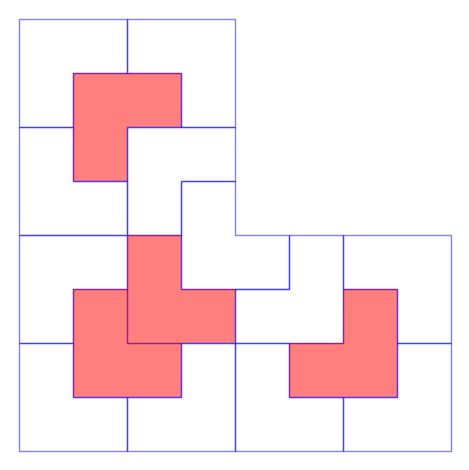

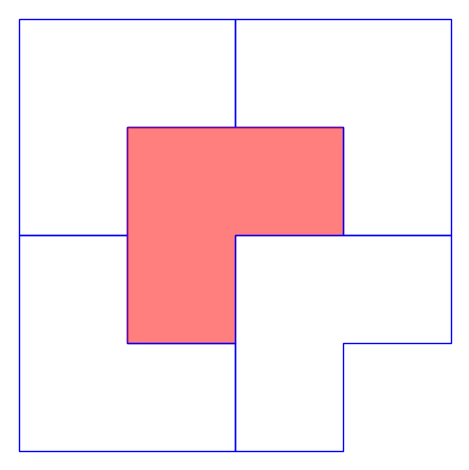

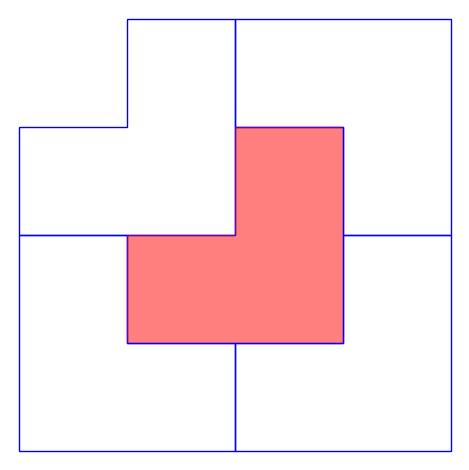

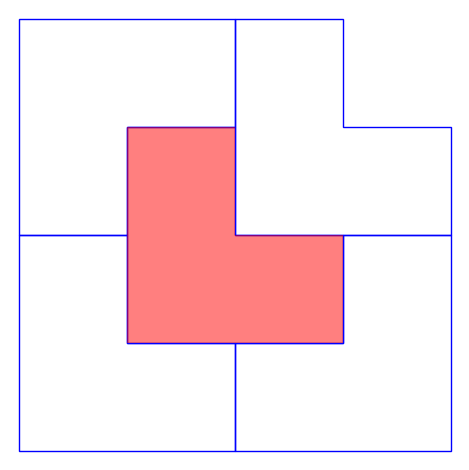

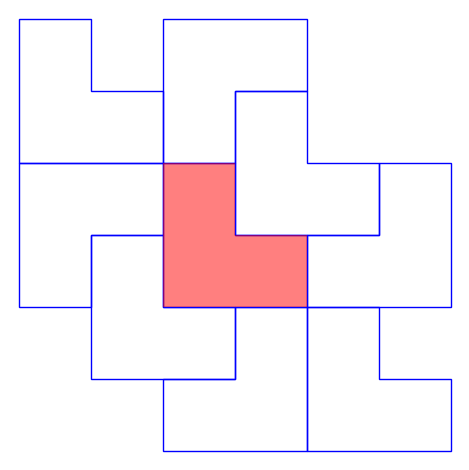

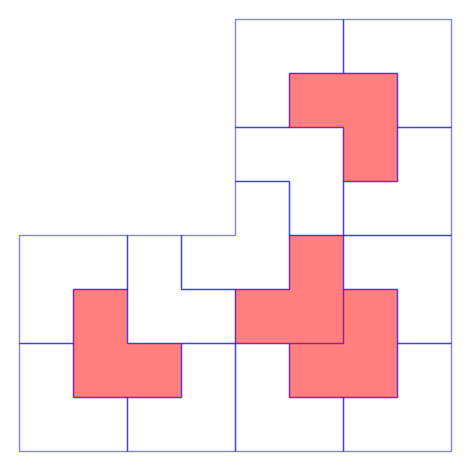

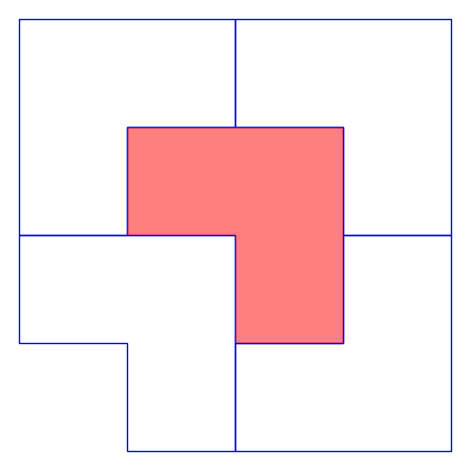

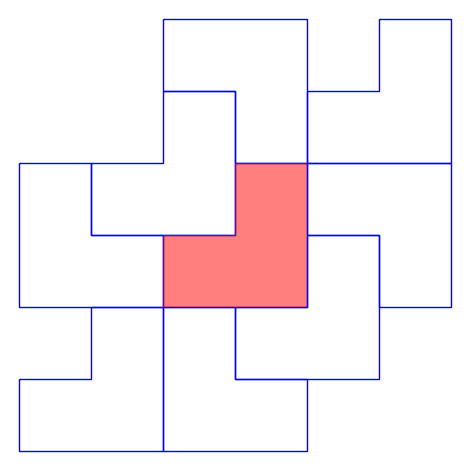

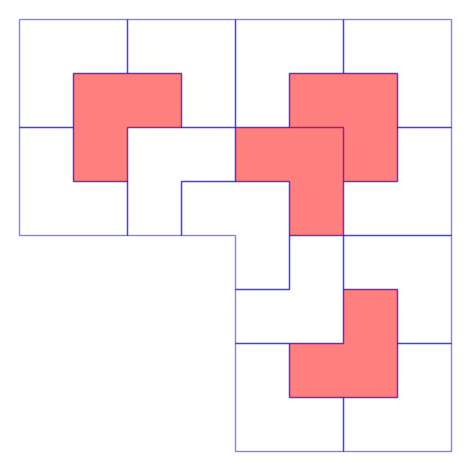

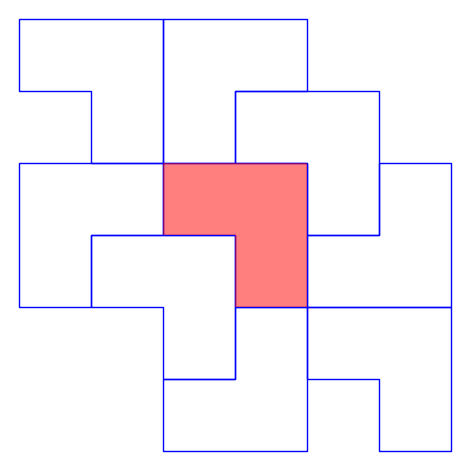

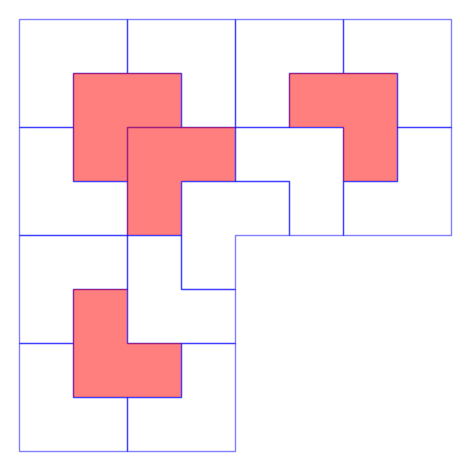

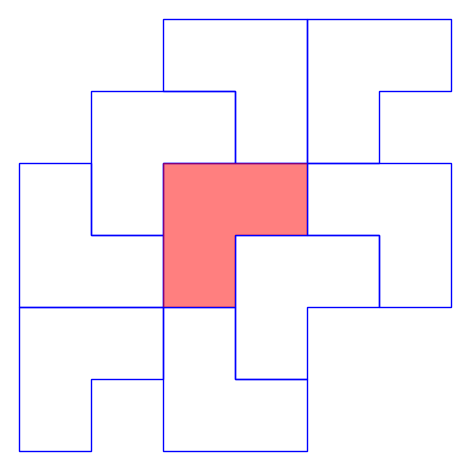

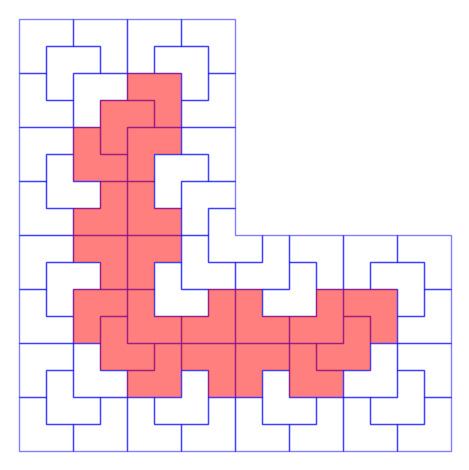

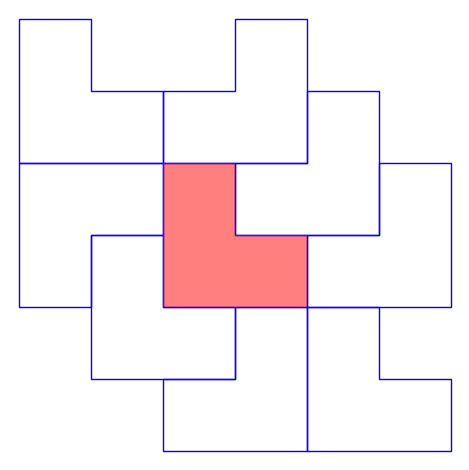

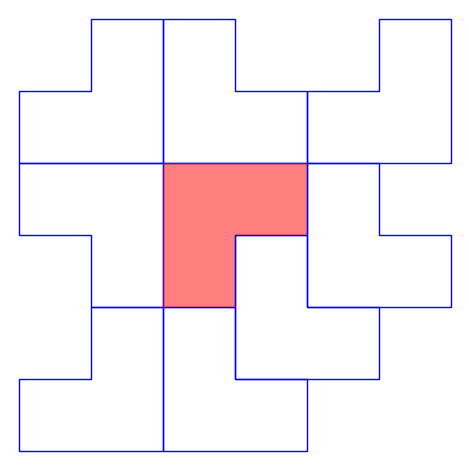

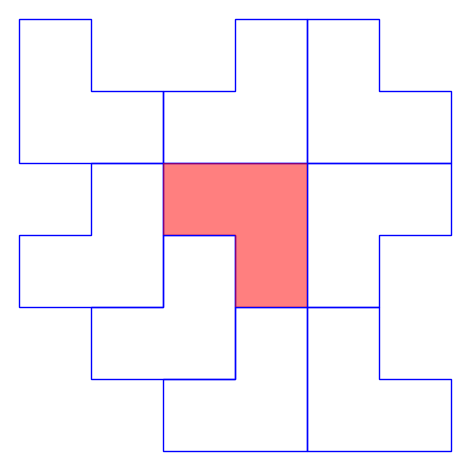

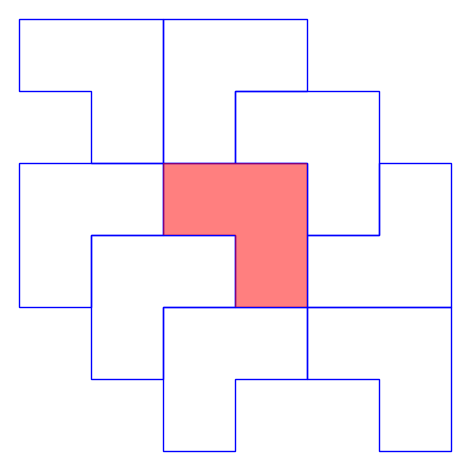

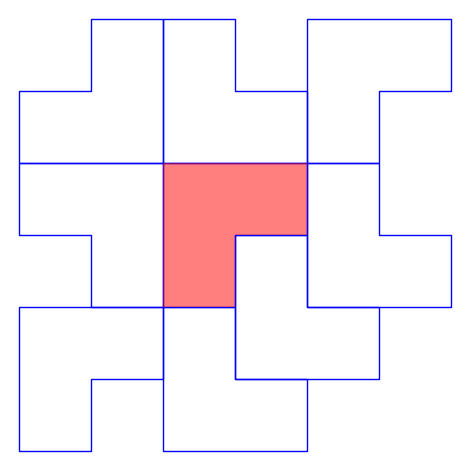

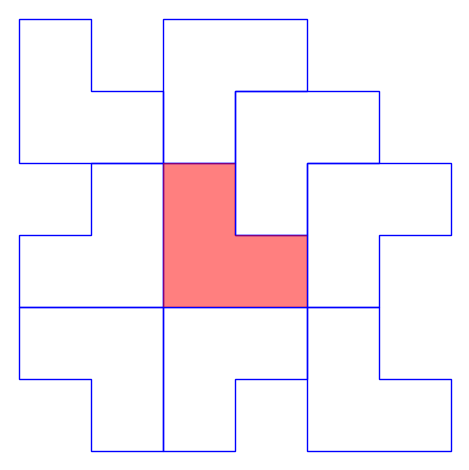

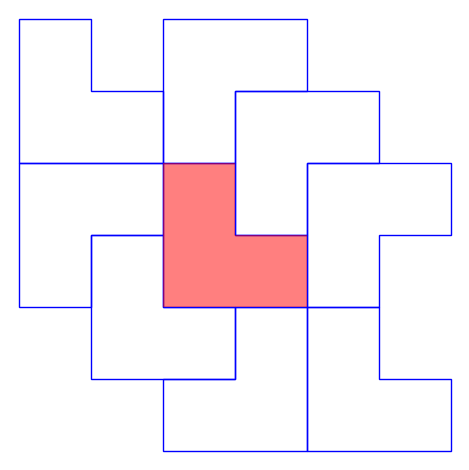

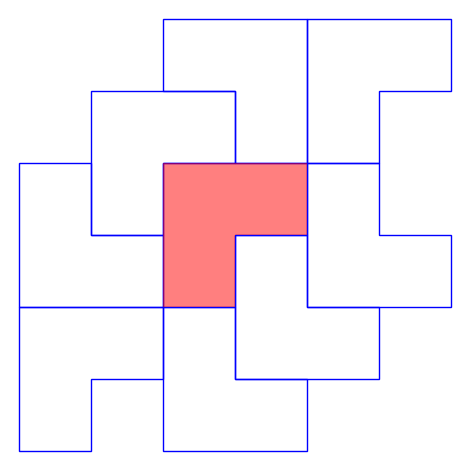

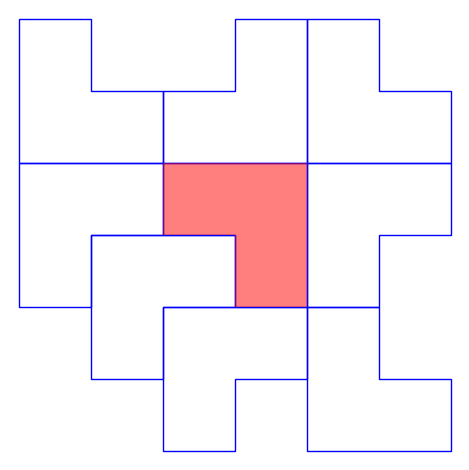

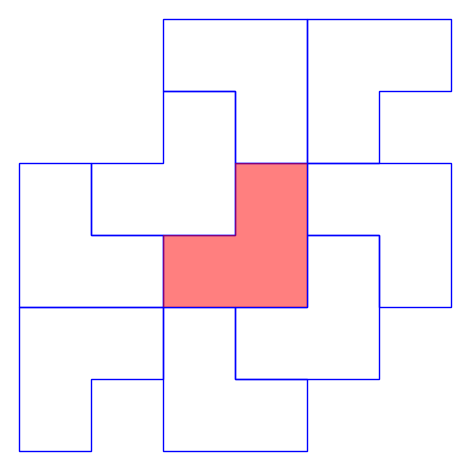

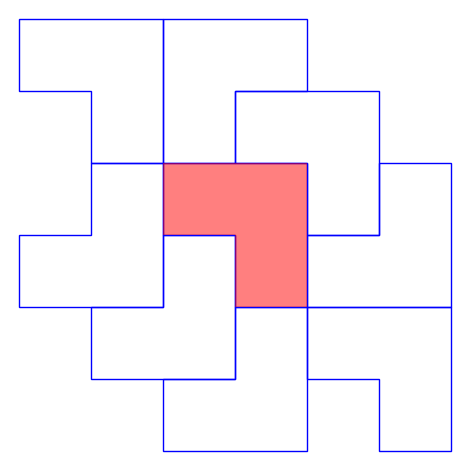

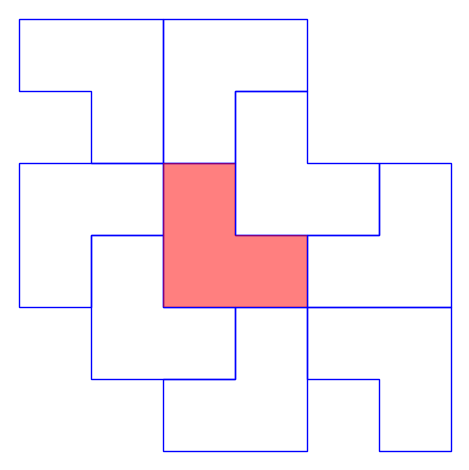

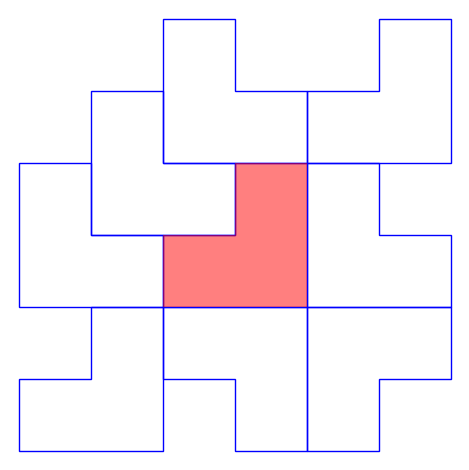

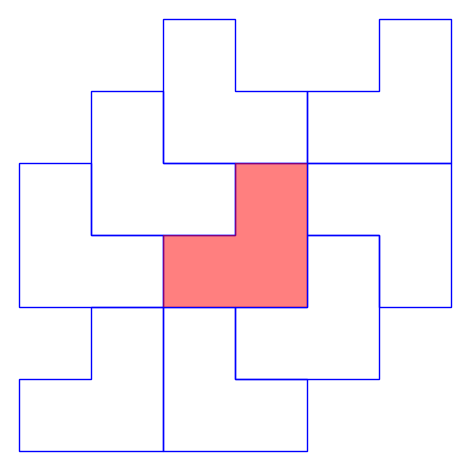

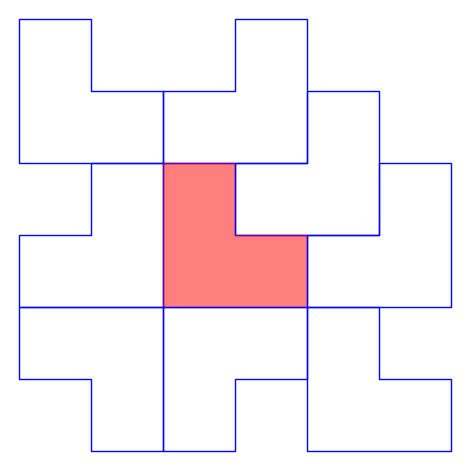

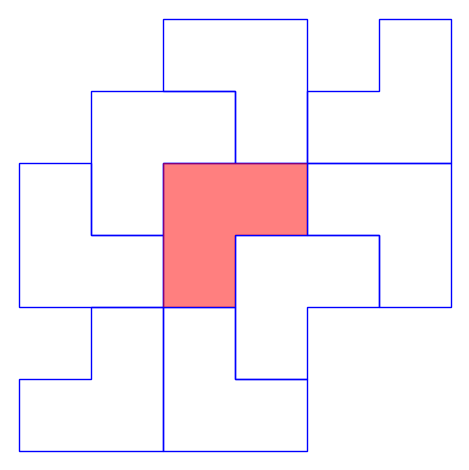

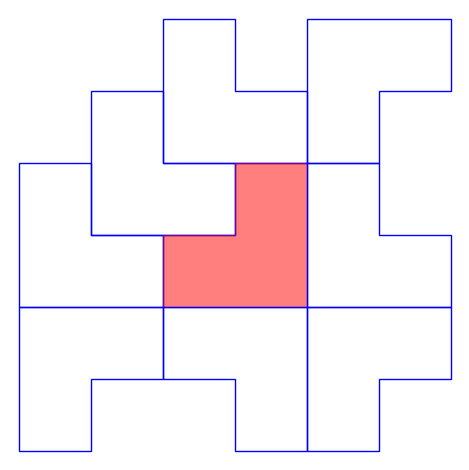

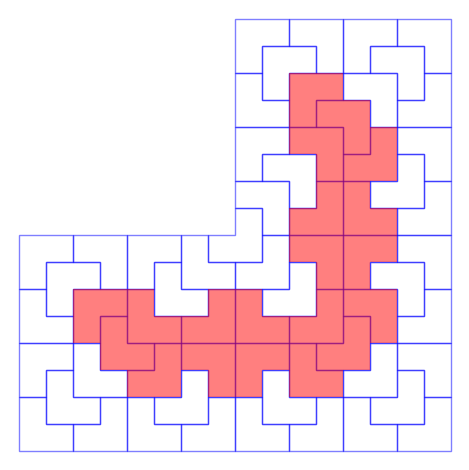

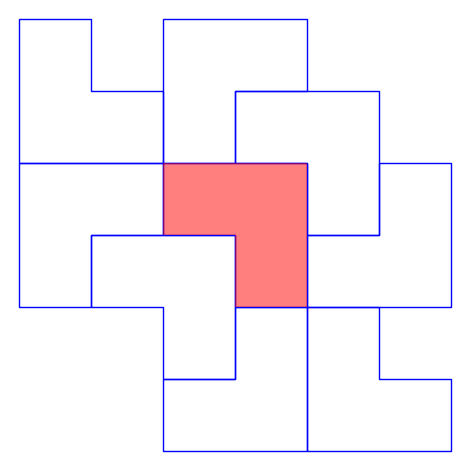

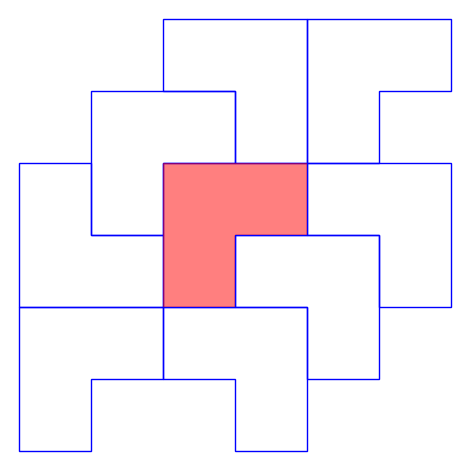

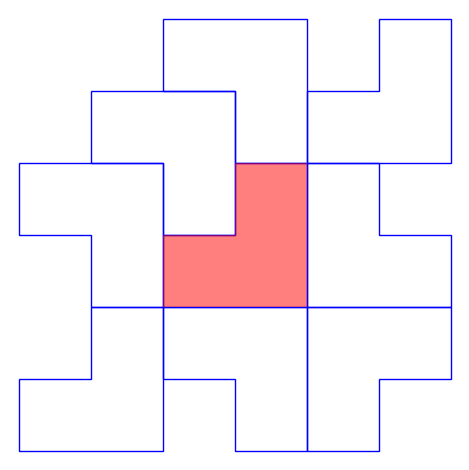

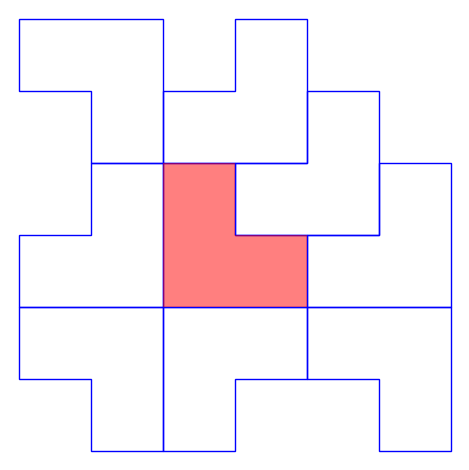

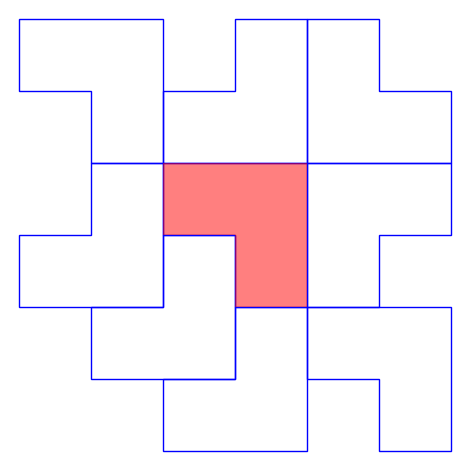

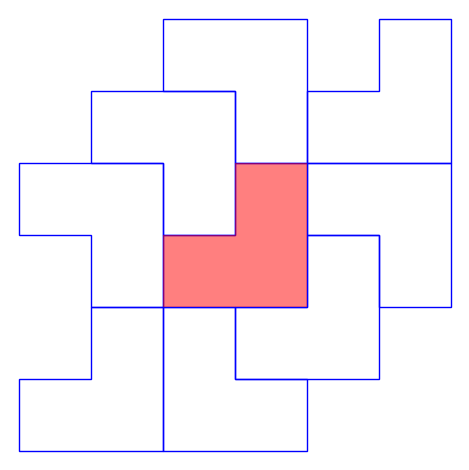

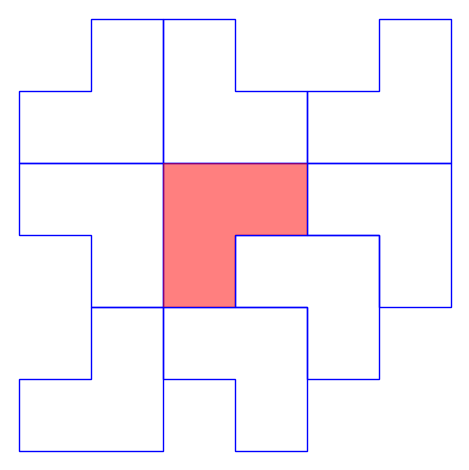

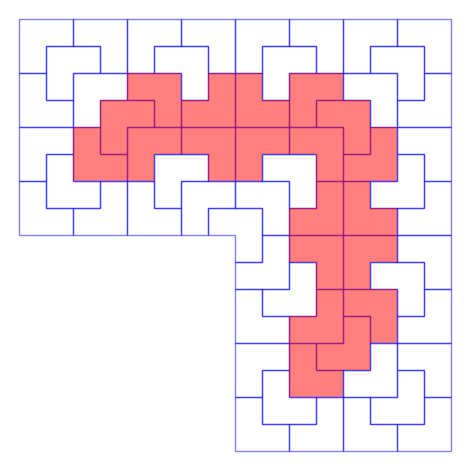

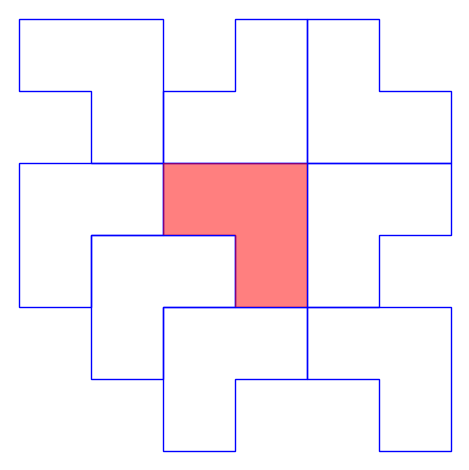

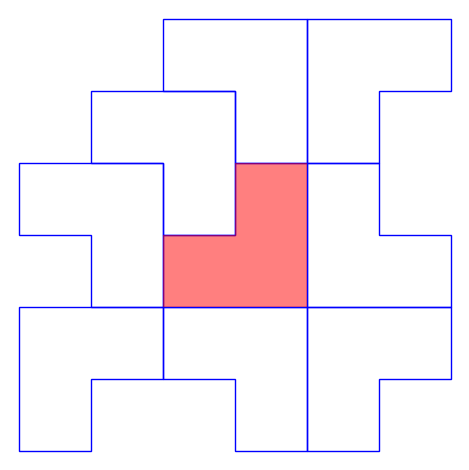

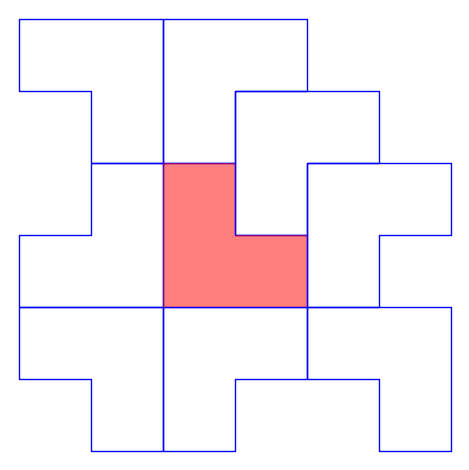

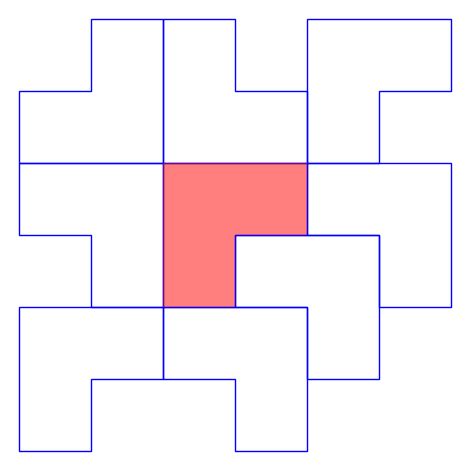

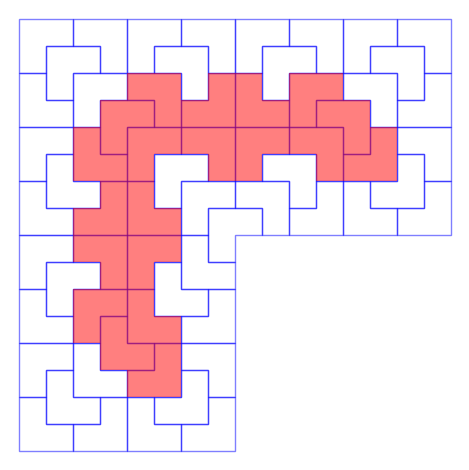

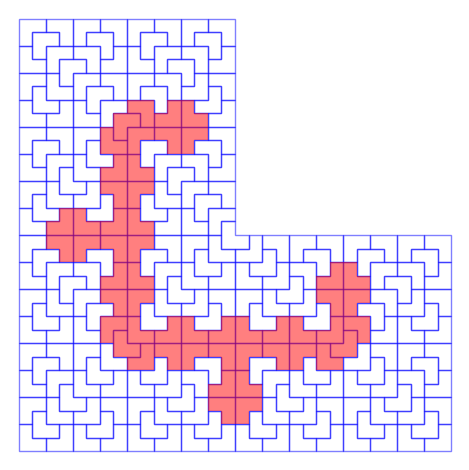

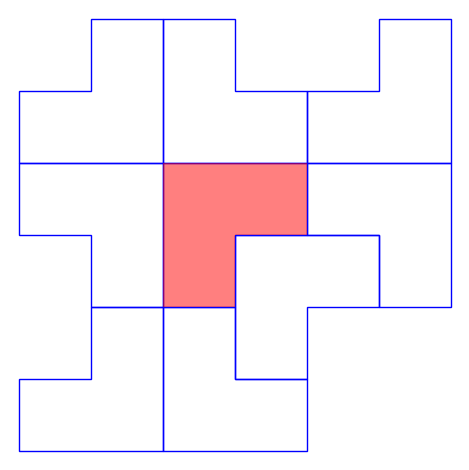

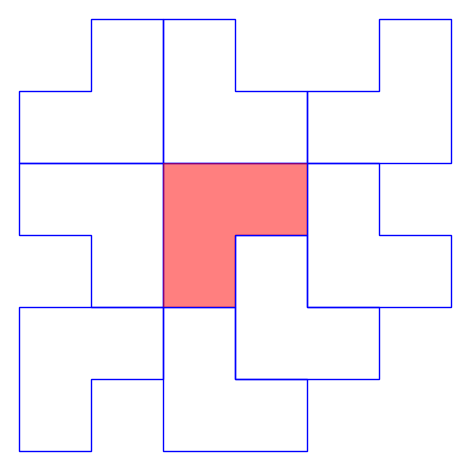

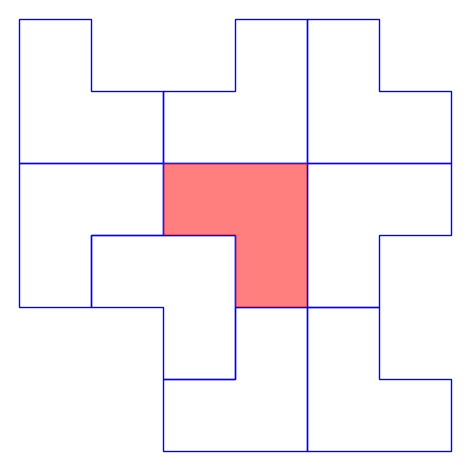

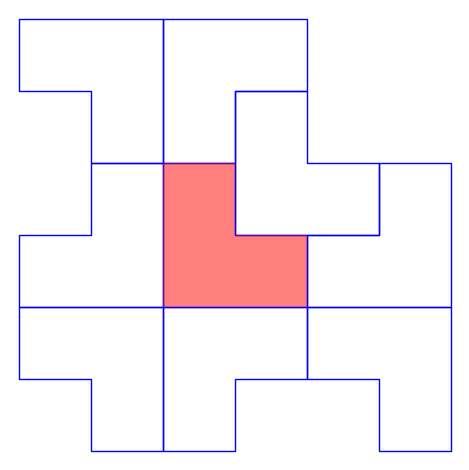

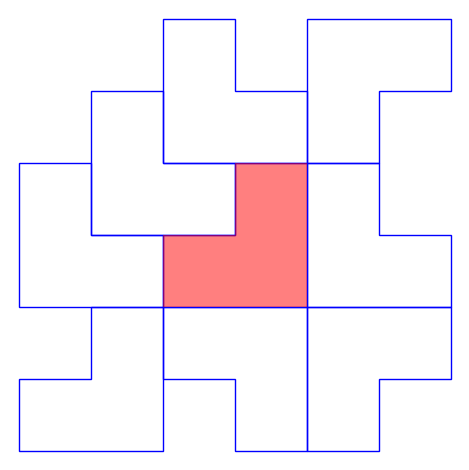

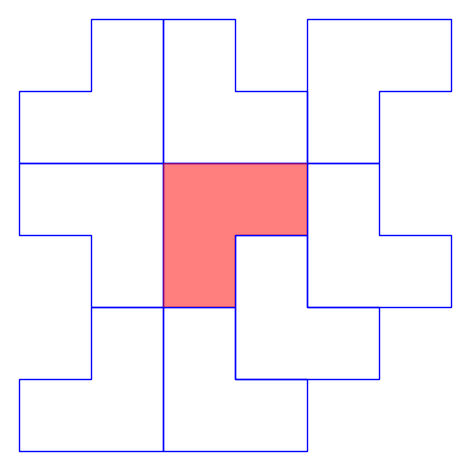

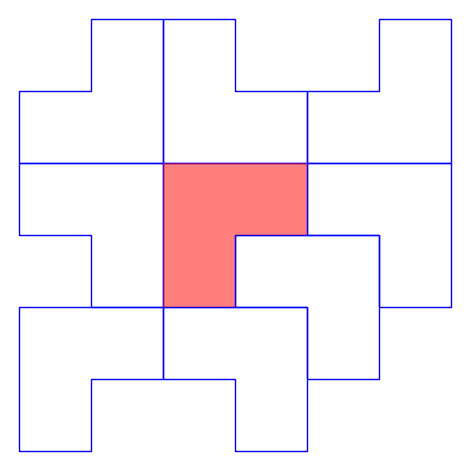

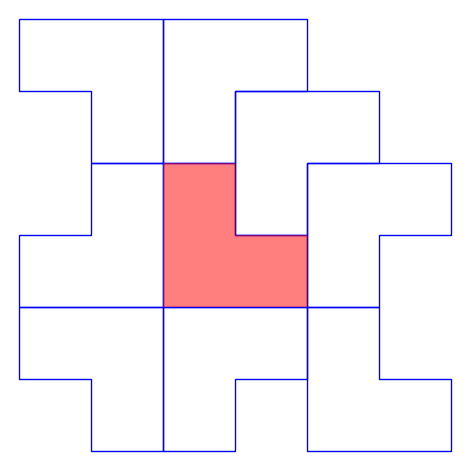

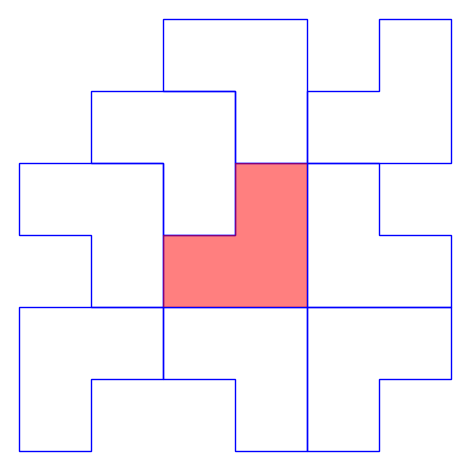

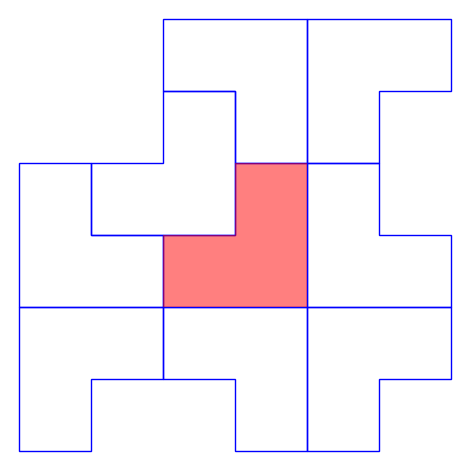

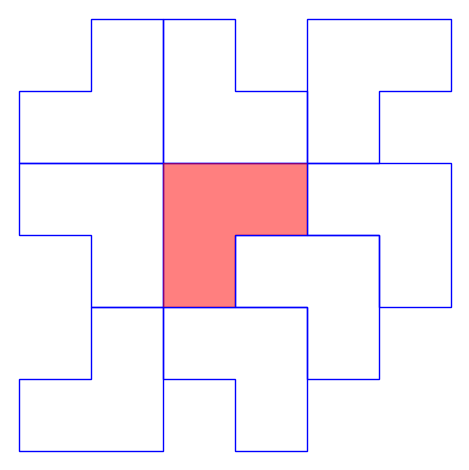

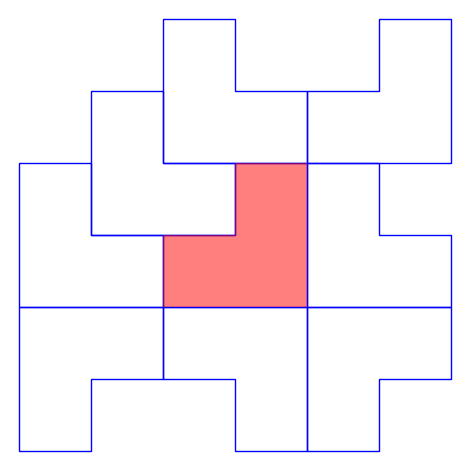

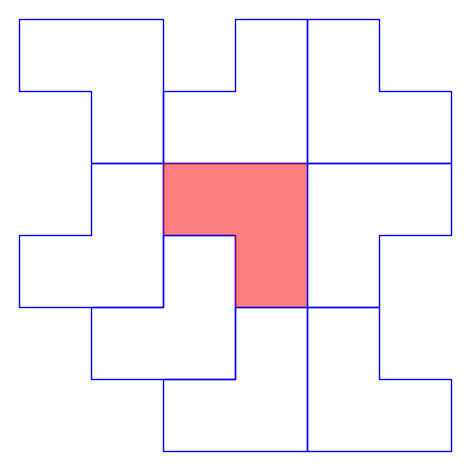

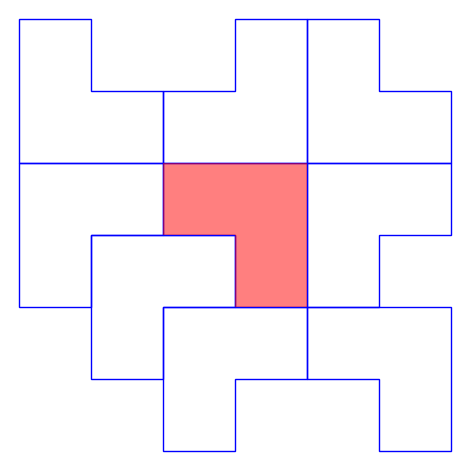

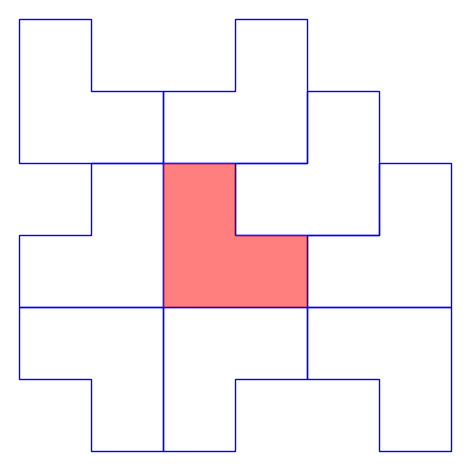

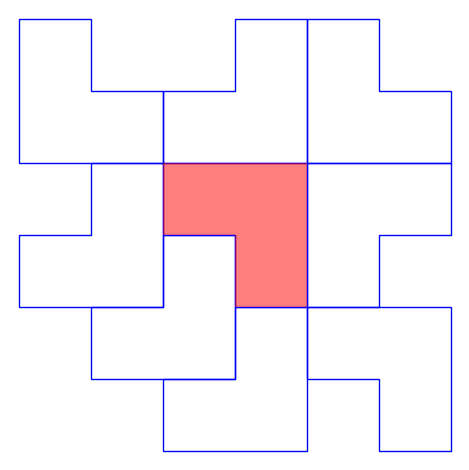

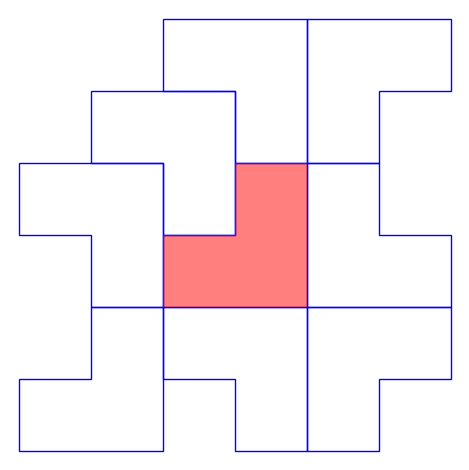

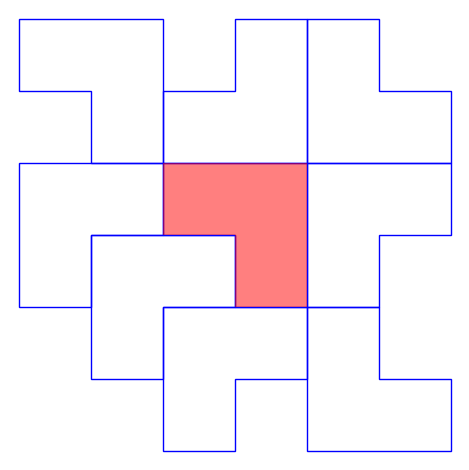

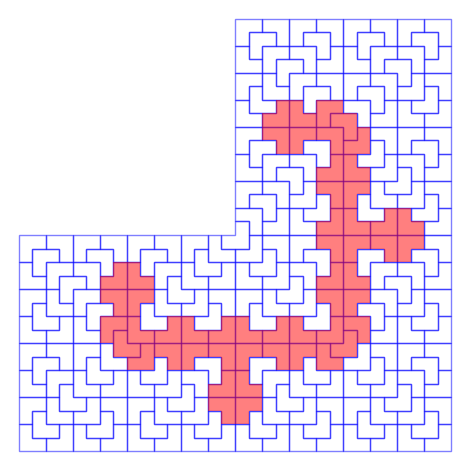

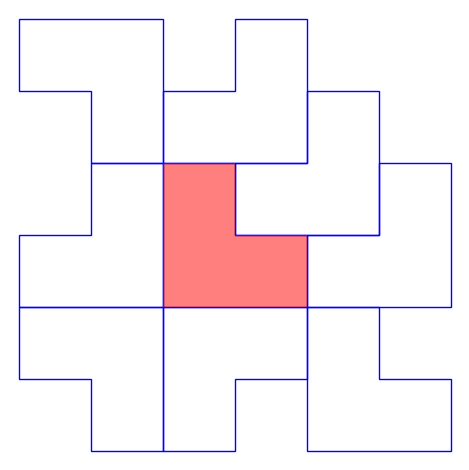

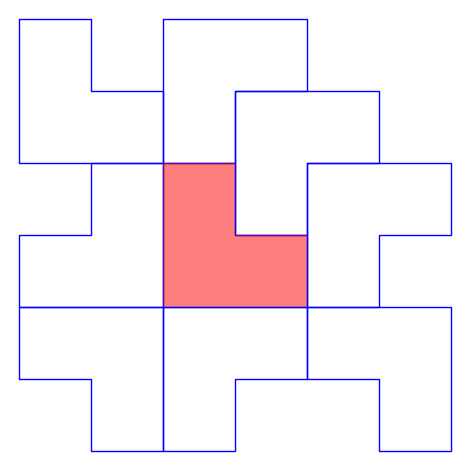

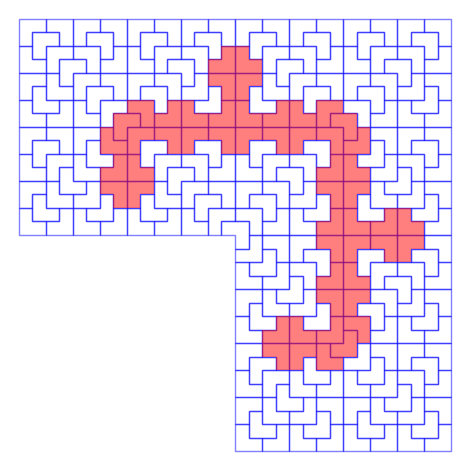

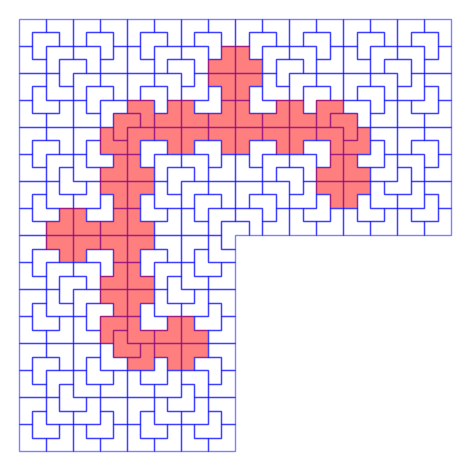

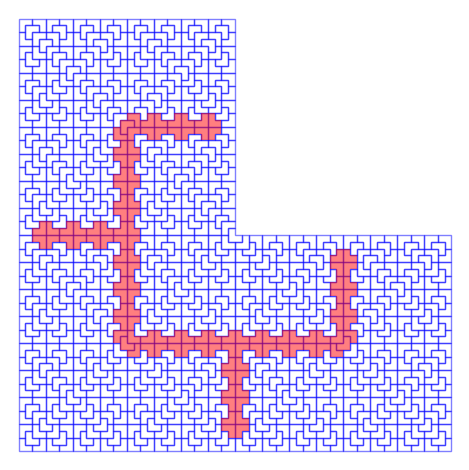

Found 56 1-collars


In [11]:

# Generate all 1-collars using the boundary trick, generating the boundary by the adjacency matrix naively (can be optimized)
num_collars = 0
num_collars_prev = -1
i = 2
collars_found = set()
# small_supertile = ChairTile(i - 1, 0, vector((0,0)), None)

# Generate all 1-collars using the boundary trick, generating the boundary by the adjacency matrix naively (can be optimized)
num_collars = 0
num_collars_prev = -1
i = 2
collars_found = set()

while num_collars != num_collars_prev:
    num_collars_prev = num_collars
    for theta in range(4):
        sup_tile = ChairTile(i, mod_2pi(pi/2 * theta), vector((0,0)), None)
        sup_tile.build_adj_matrix()
        sup_tile.find_border_matrix(1)
        show(highlight_border_tiles(sup_tile))
        
        for t in sup_tile.border_tiles:
            patch = Patch()
            s = find_k_neighbors(sup_tile, t, 1)
            patch.add_tile(t)
            
            for tile in s:
                patch.add_tile(tile)
                
            if patch in collars_found:
                continue
            
            num_collars += 1
            collars_found.add(patch)
            G = patch.display_patch(t)
            show(G)
            # G.save(f'chair_collar_{num_collars}.png')

        if num_collars == num_collars_prev:
            break

    # small_supertile = large_supertile
    i += 1

print(f"Found {num_collars} 1-collars")


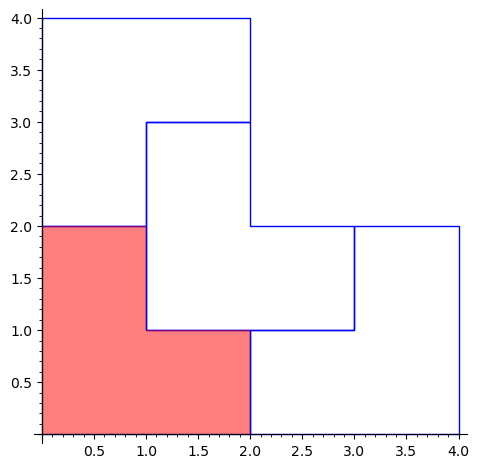

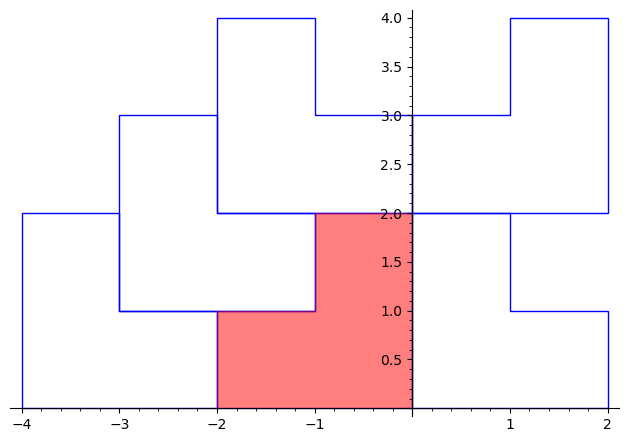

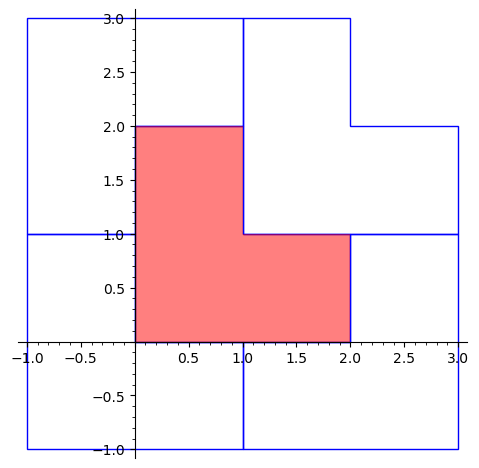

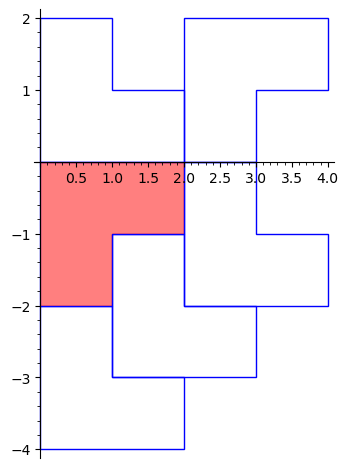

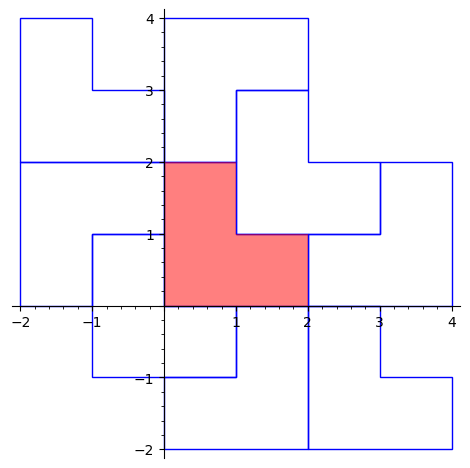

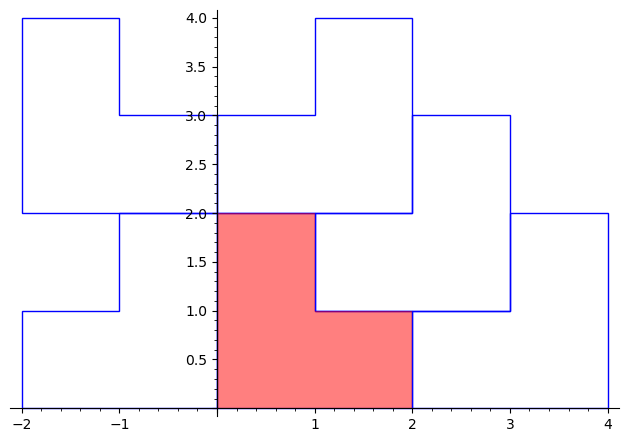

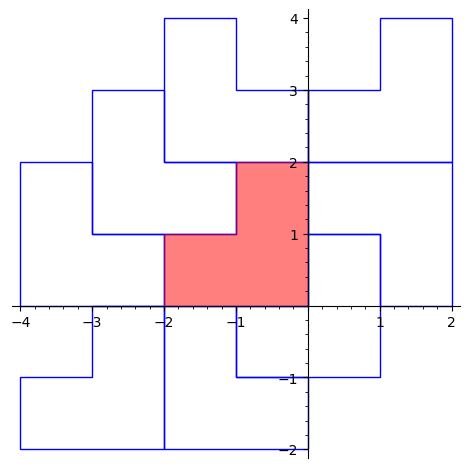

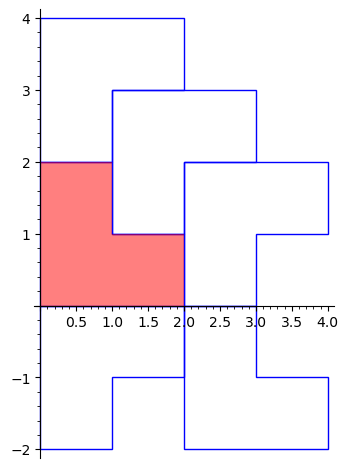

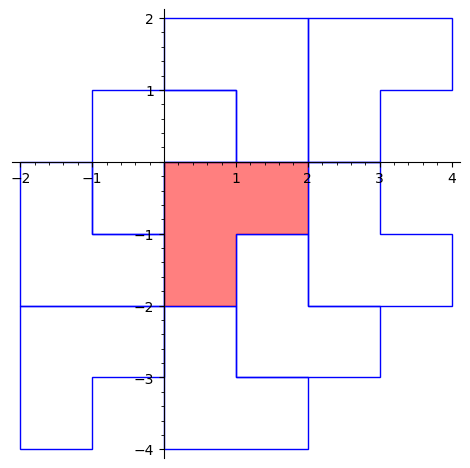

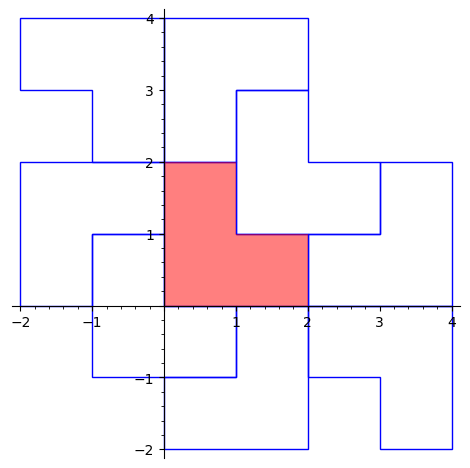

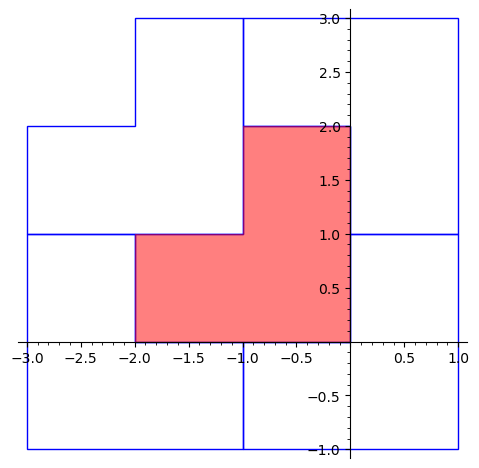

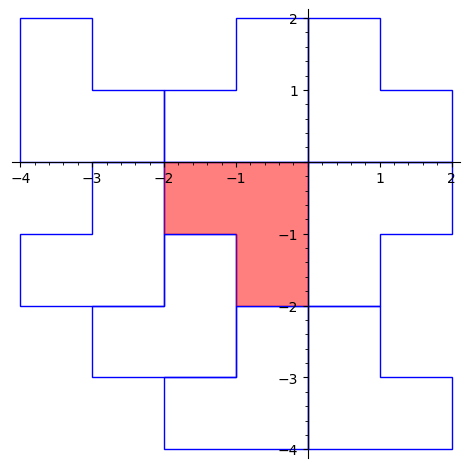

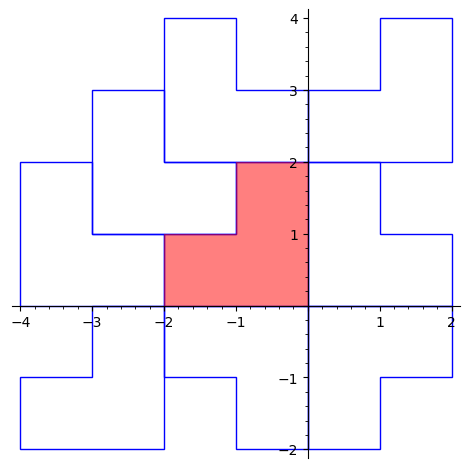

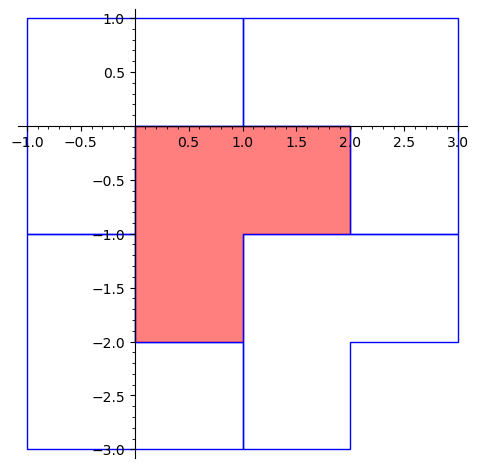

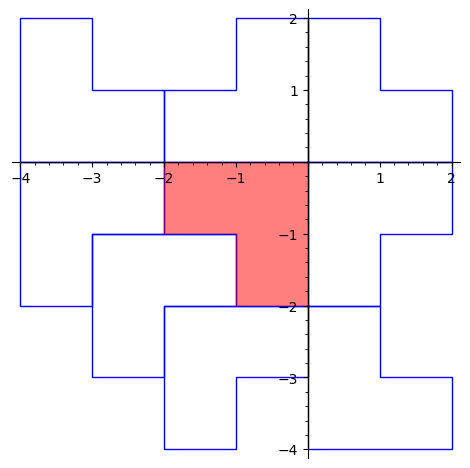

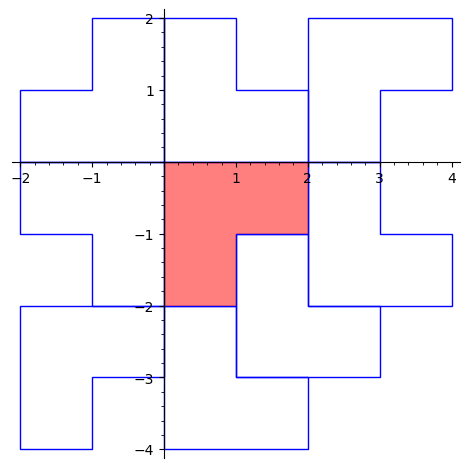

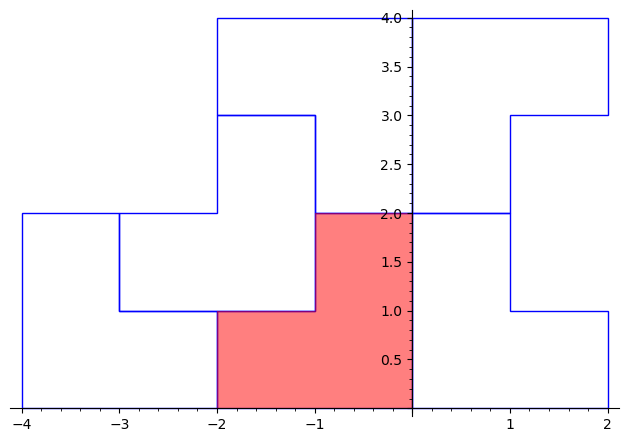

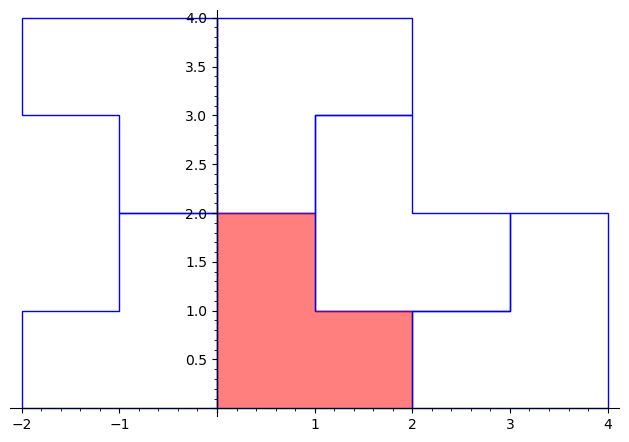

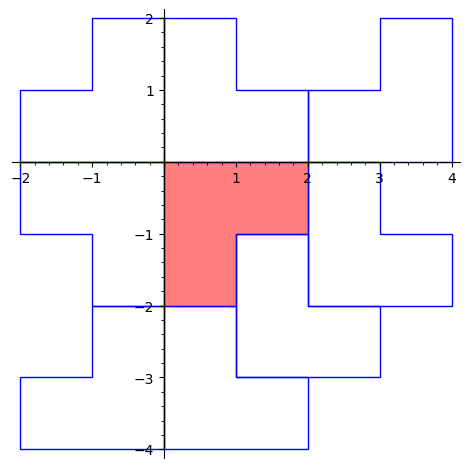

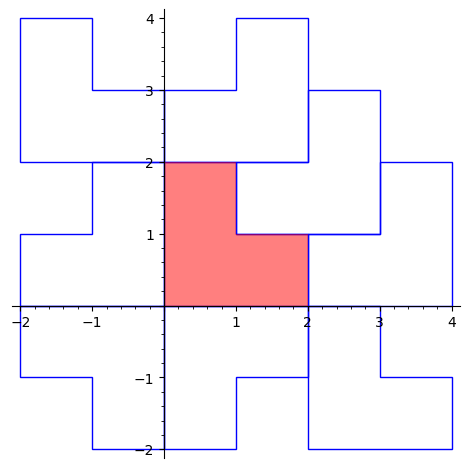

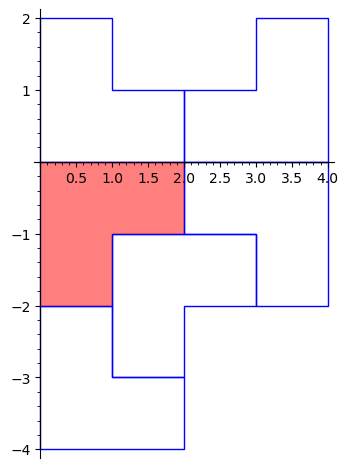

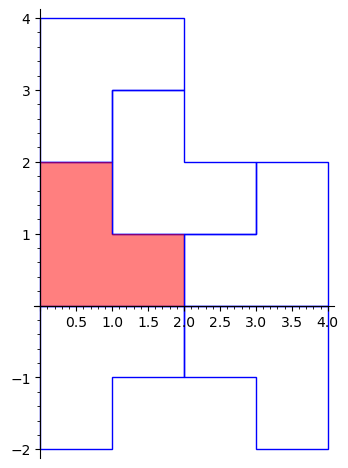

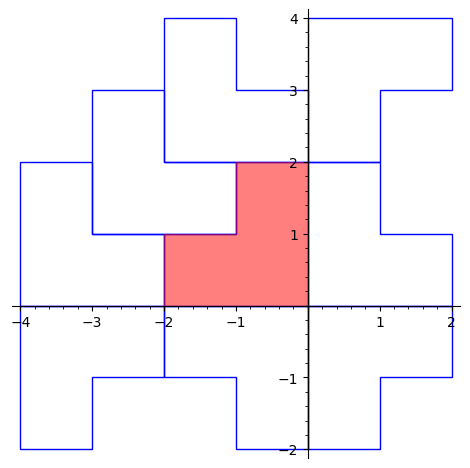

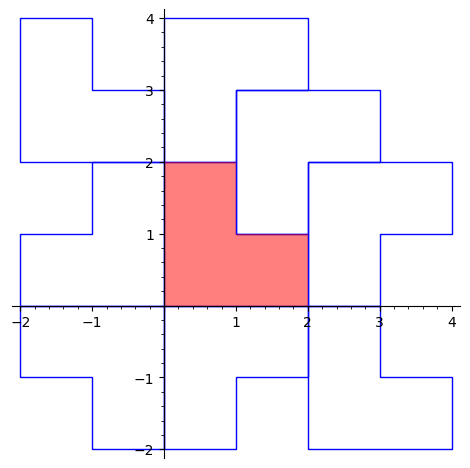

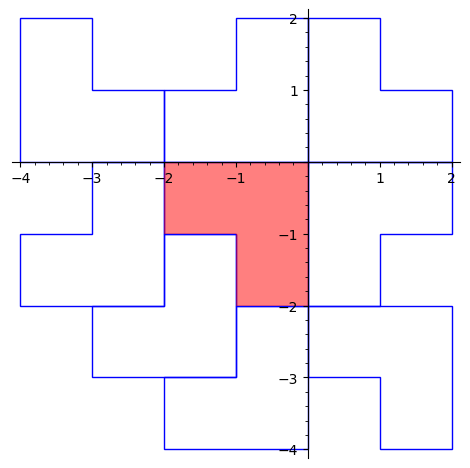

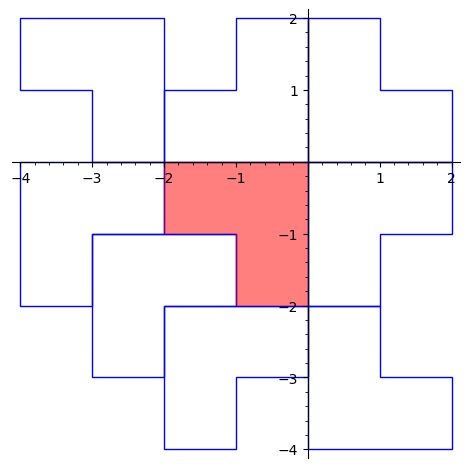

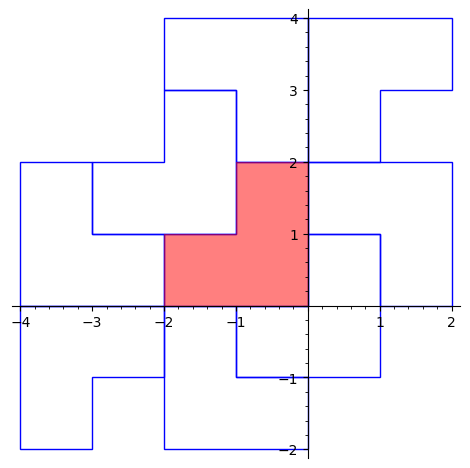

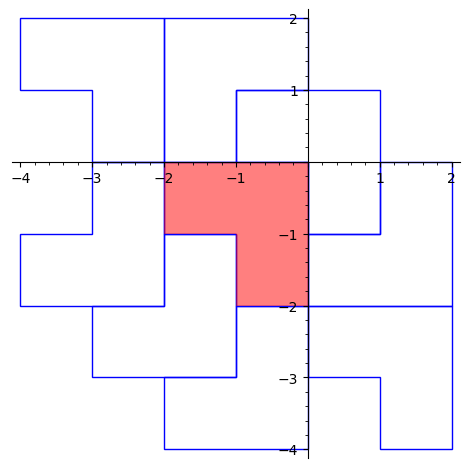

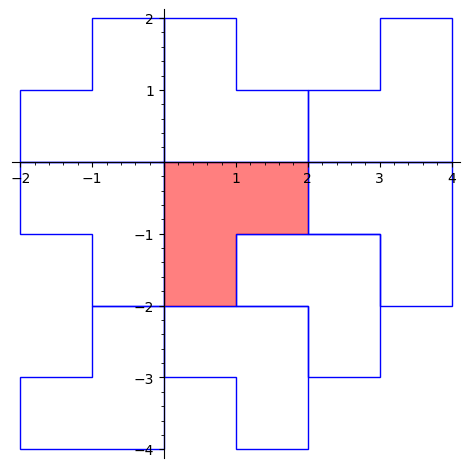

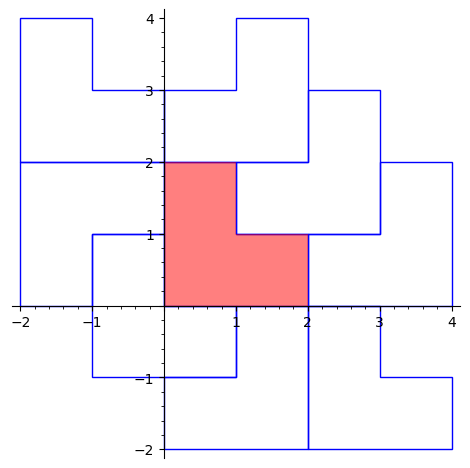

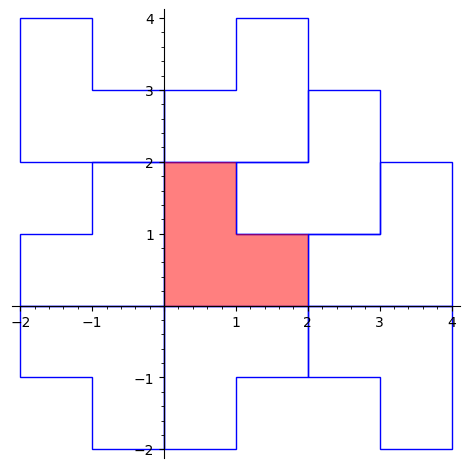

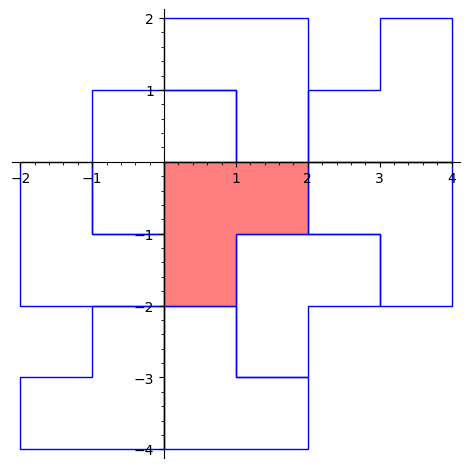

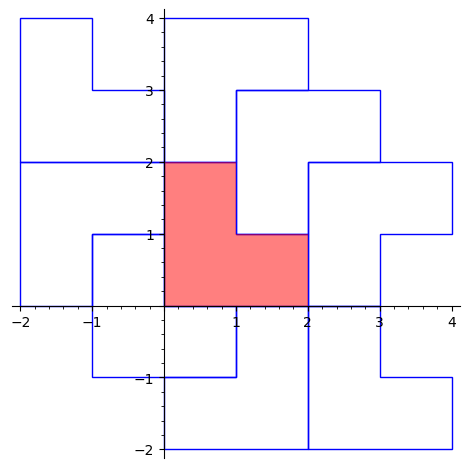

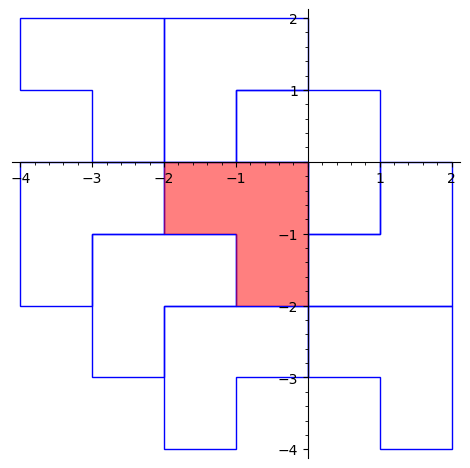

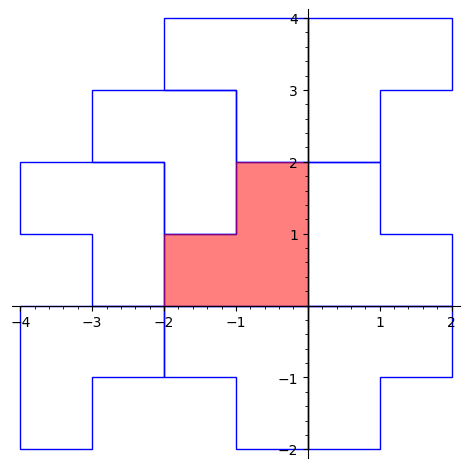

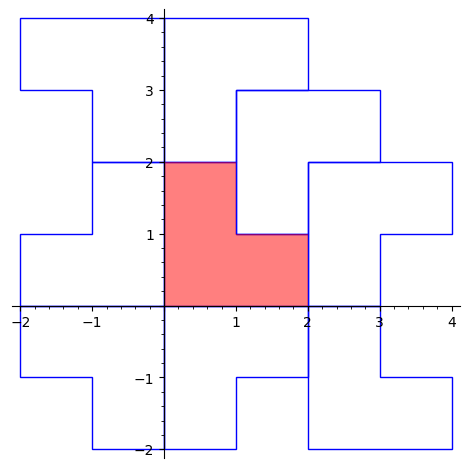

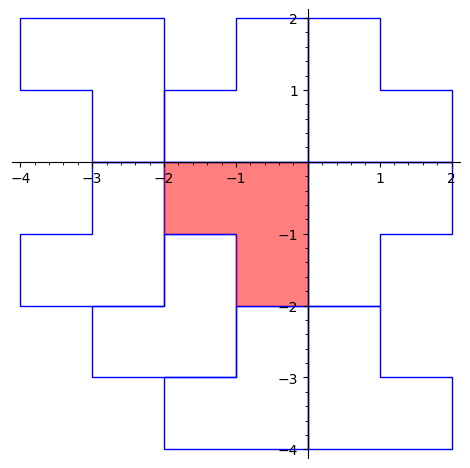

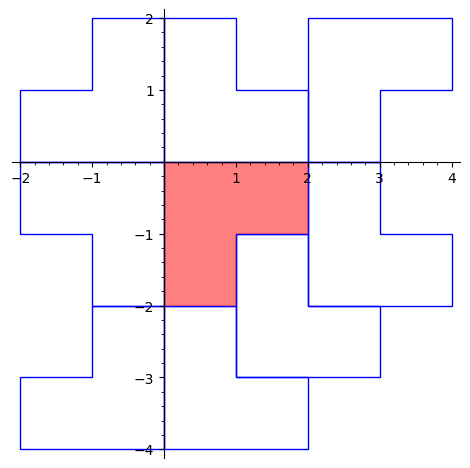

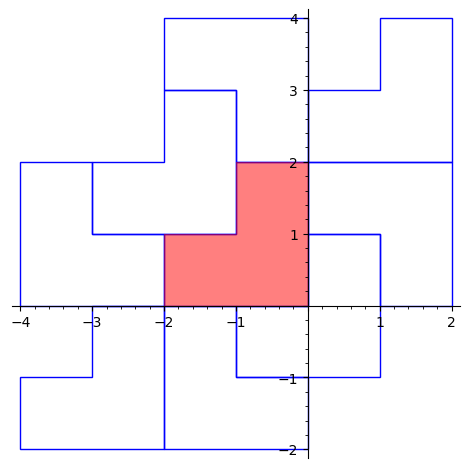

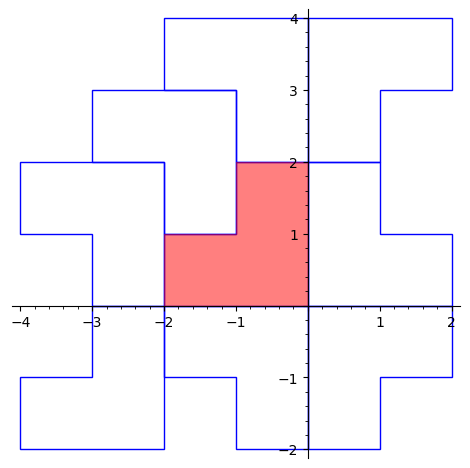

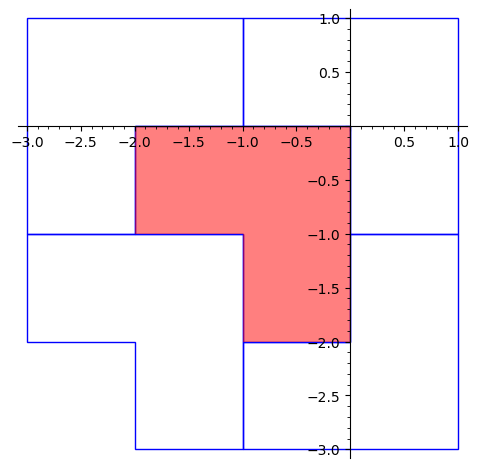

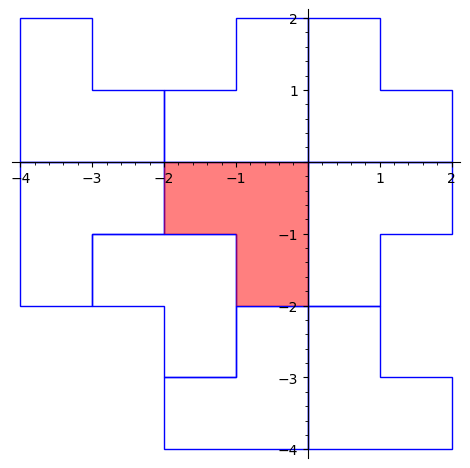

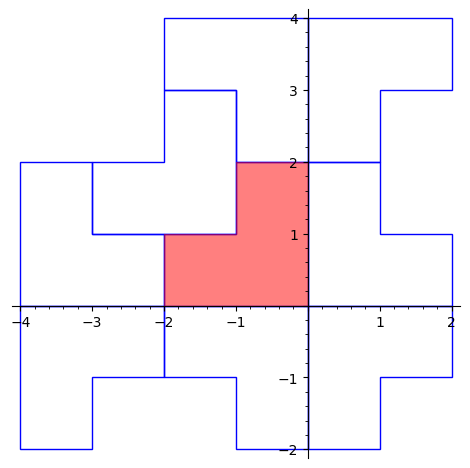

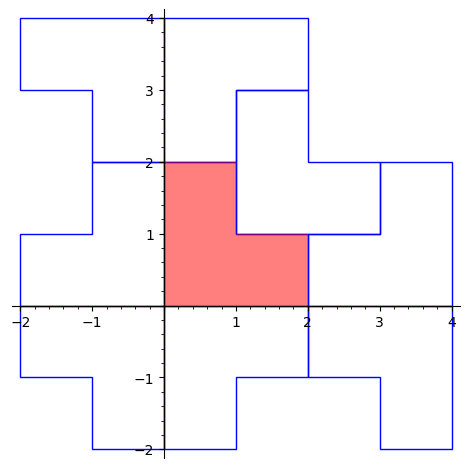

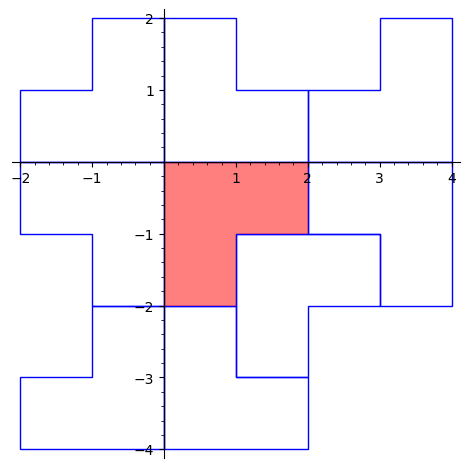

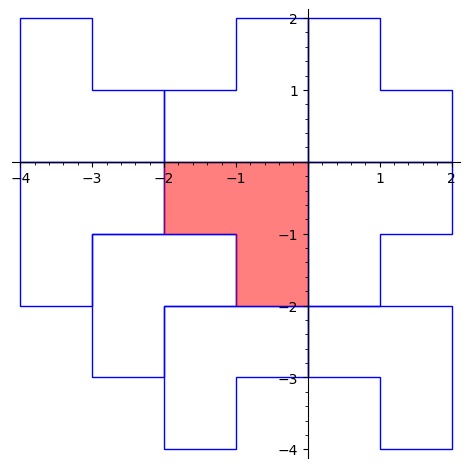

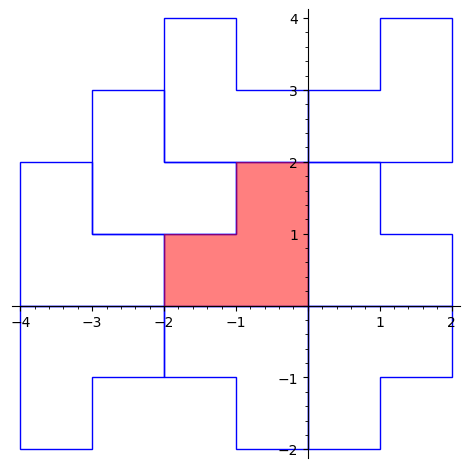

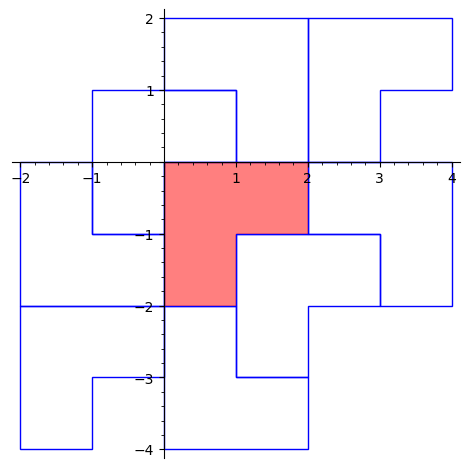

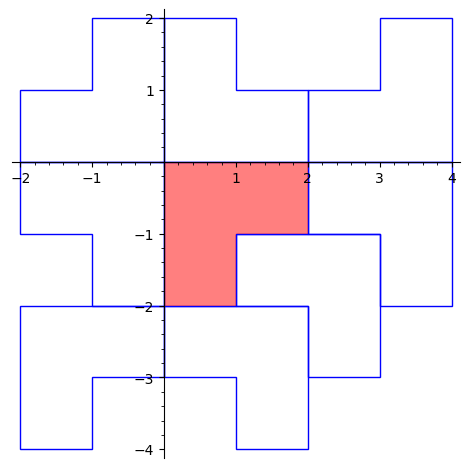

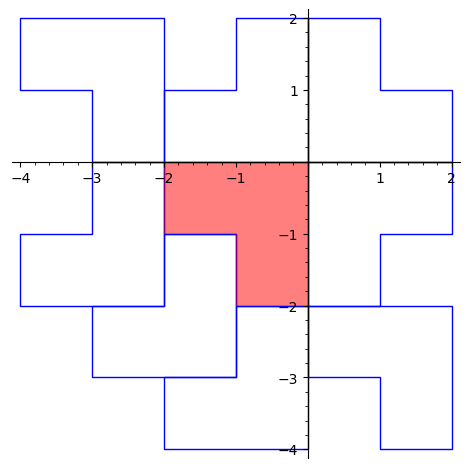

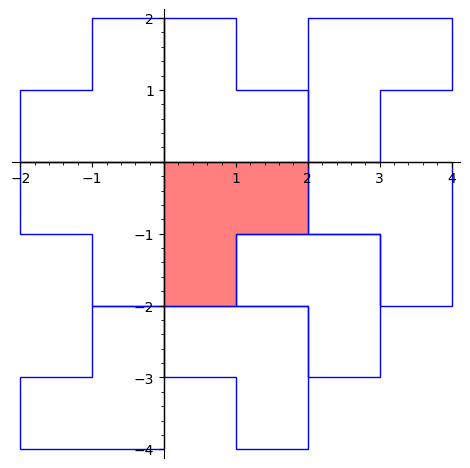

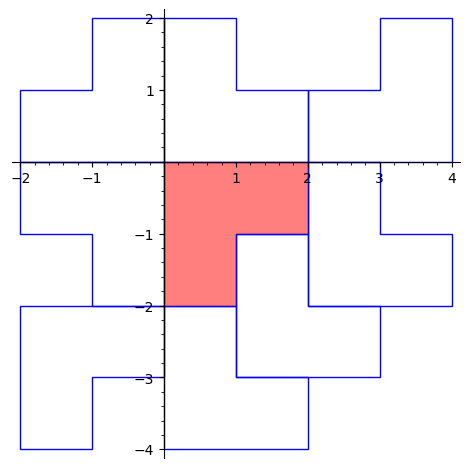

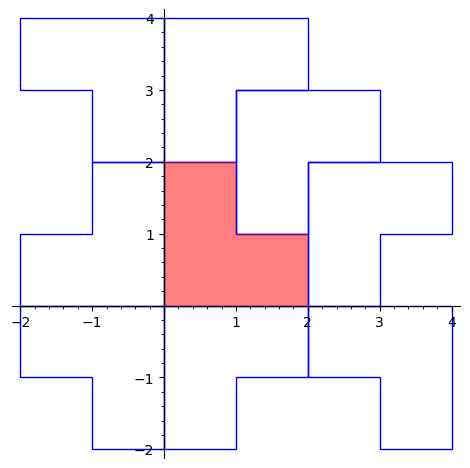

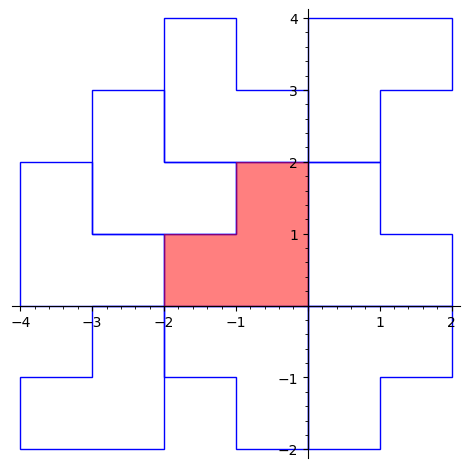

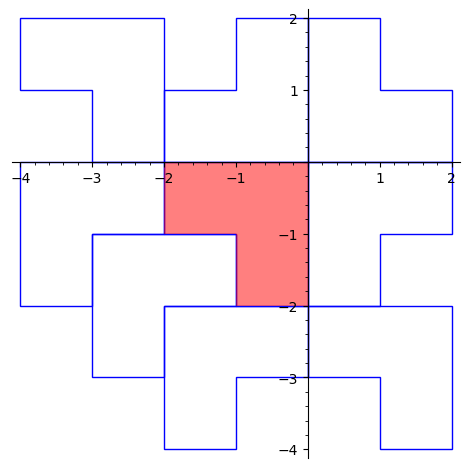

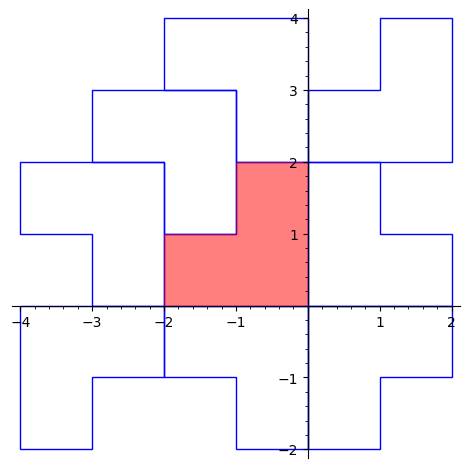

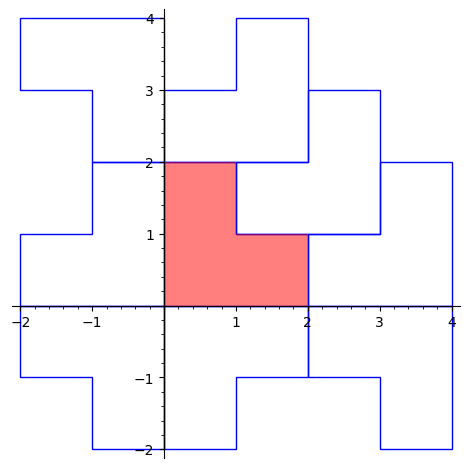

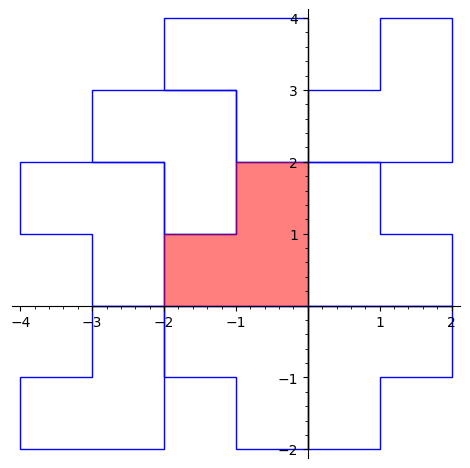

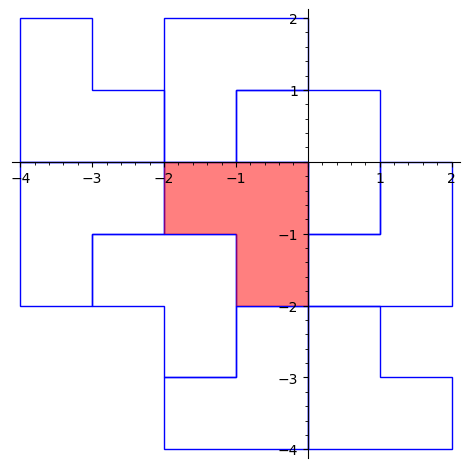

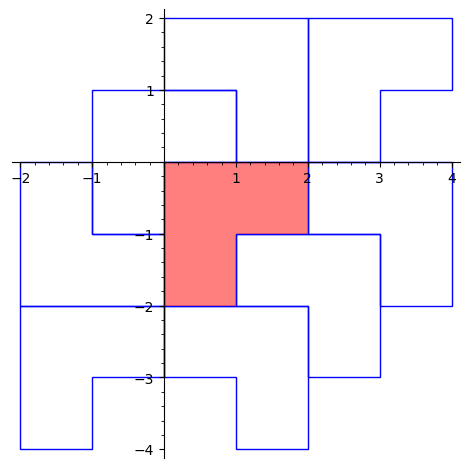

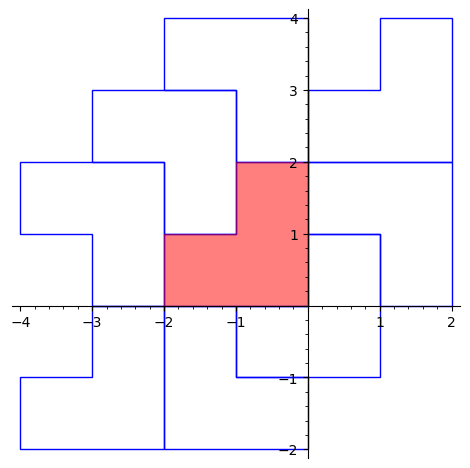

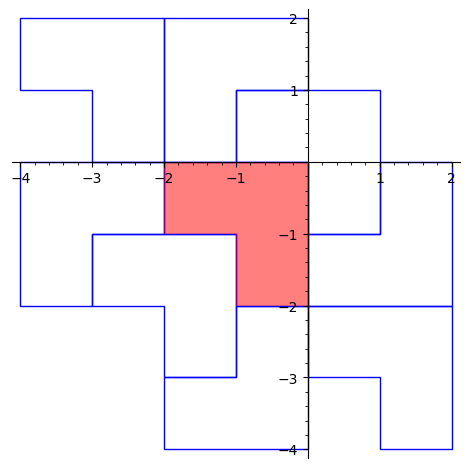

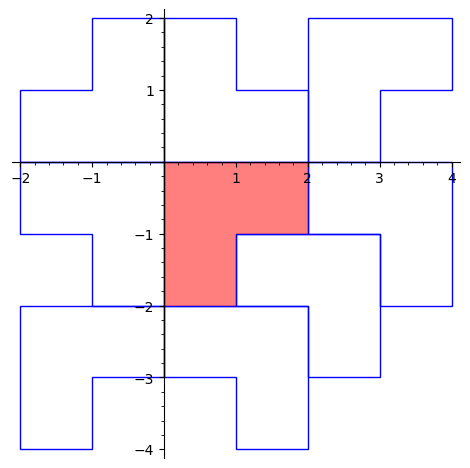

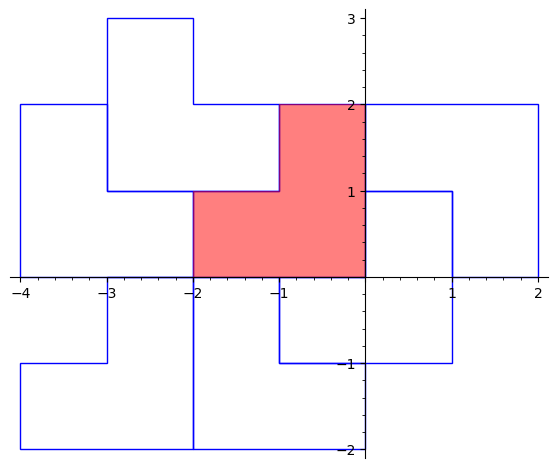

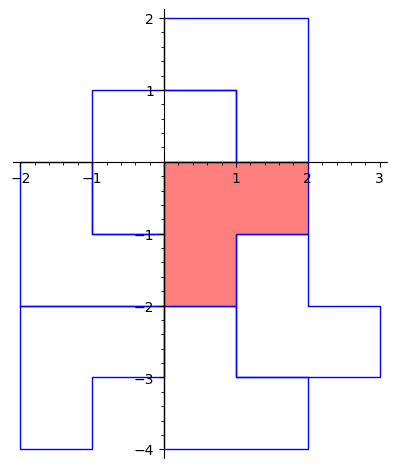

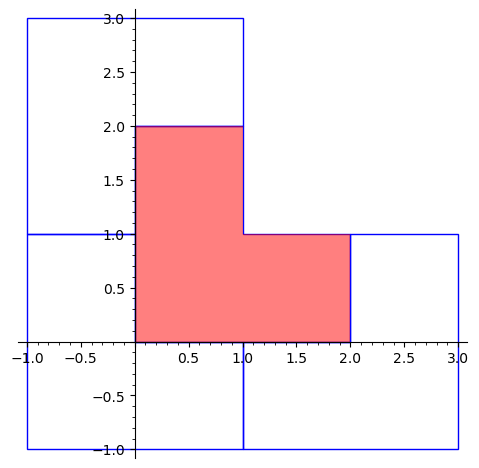

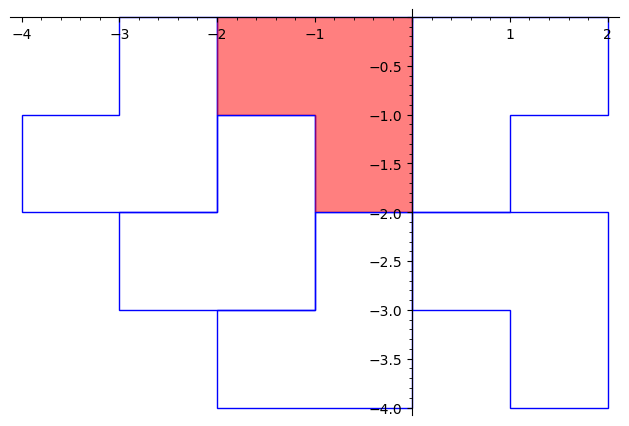

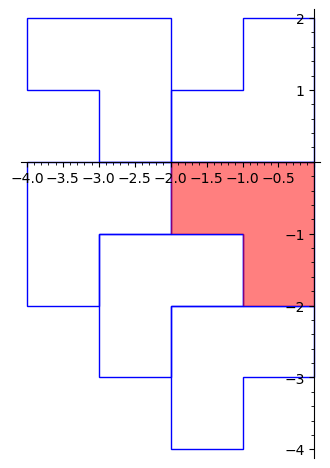

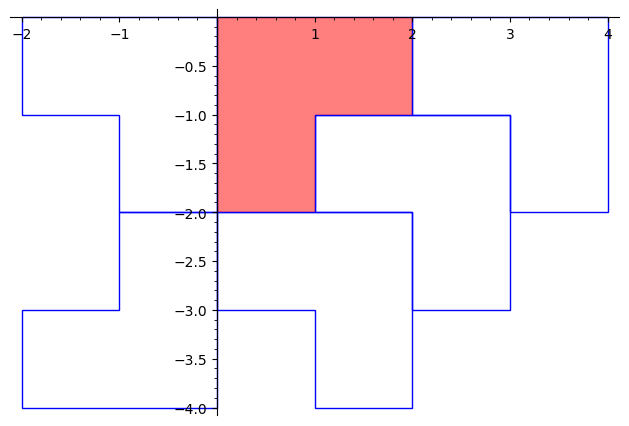

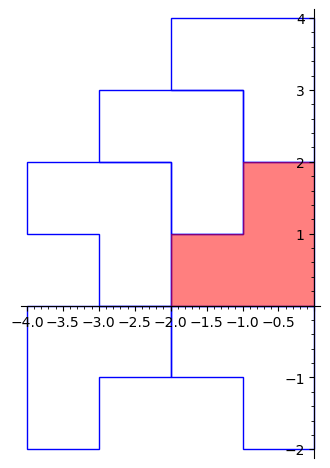

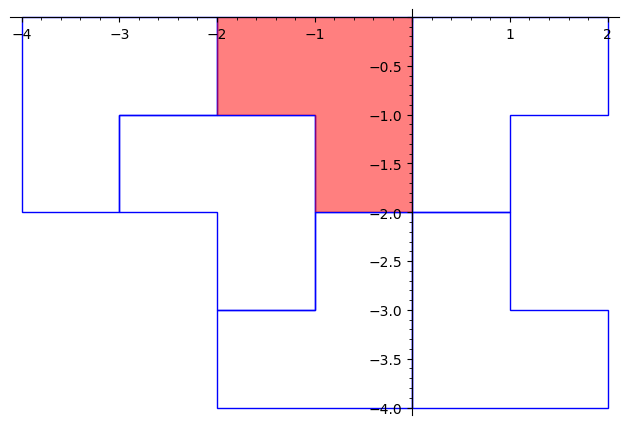

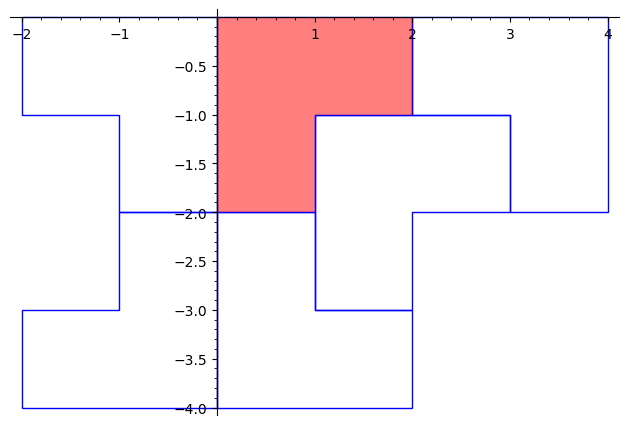

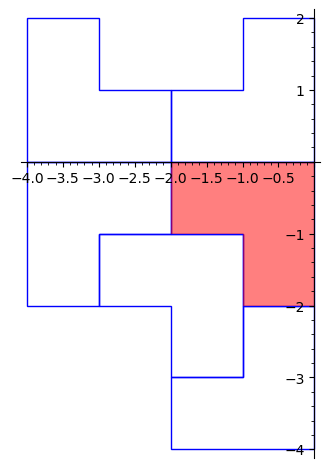

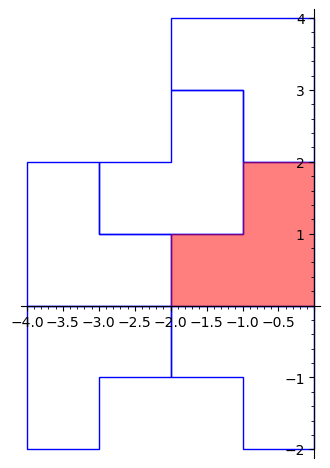

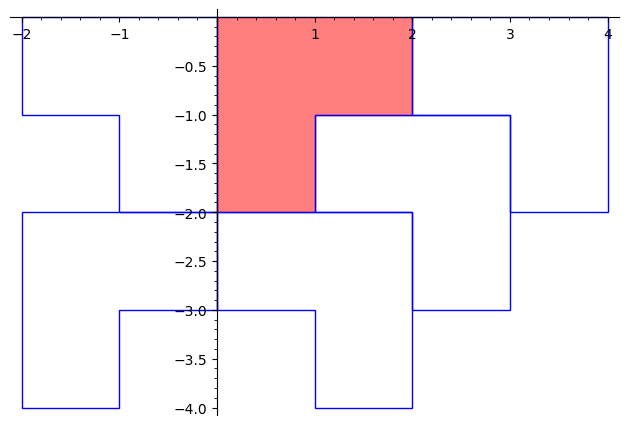

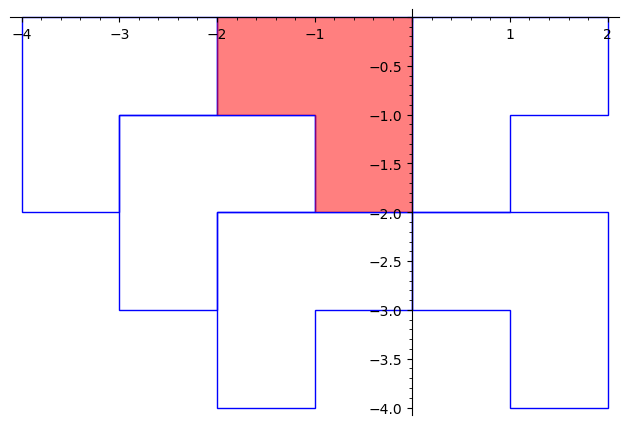

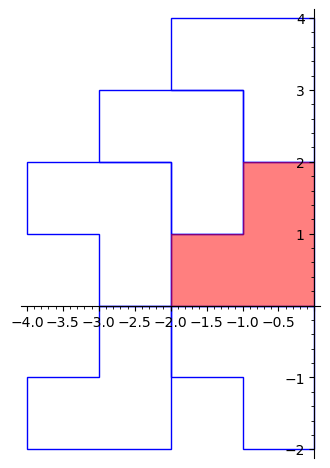

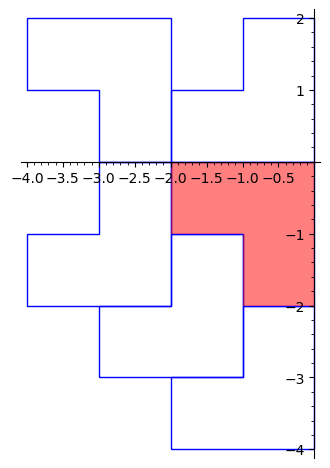

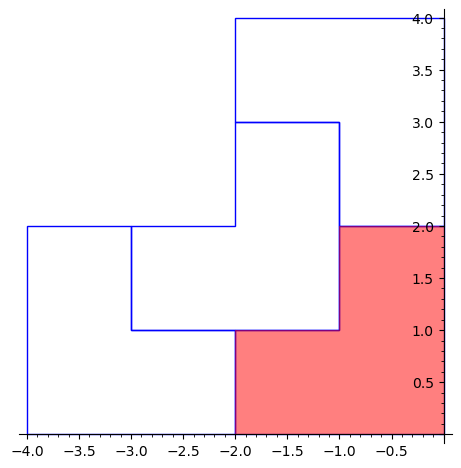

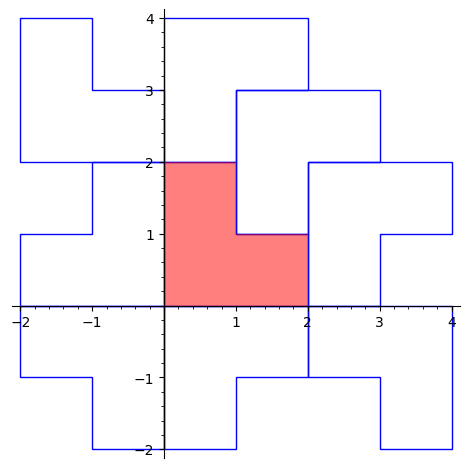

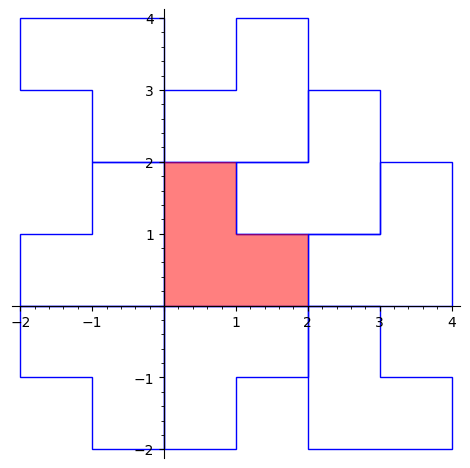

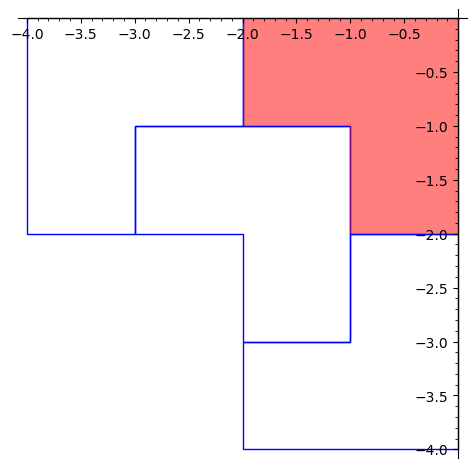

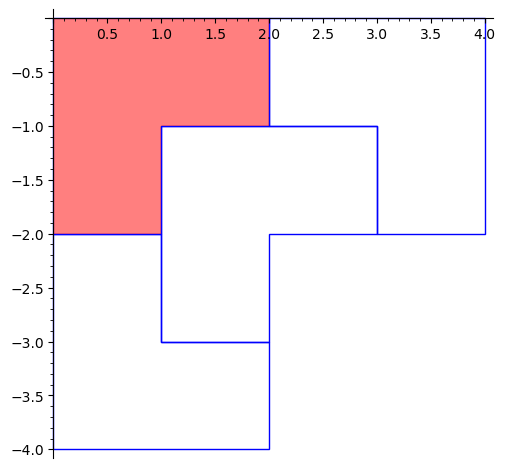

83


In [75]:
# Use this for testing if the tiling 'looks' right. We shouldn't be using graphics for actually
# doing any work with a tile object. 

p = ChairTile(5, 0, vector((0,0)), None)

# Displays a supertile s graphically
def display_tiles(s):
    G = Graphics()
    if s.level == 0:
        return polygon(s.points, fill=false)
    else:
        for c in s.subtiles:
            G += display_tiles(c)
    return G

# Display all 1-neighborhoods of all prototiles in p. TODO: update to find all 
# k-neighborhoods, and don't include boundary tiles. Also, avoid finding repeated
# neighborhoods, i.e. make two patches equal if the tiles in the patch are all
# placed at the same points relative to each other. So a patch should be 'equal'
# to a translation of the same patch, for avoiding repetitions. 
one_collars = 0
visited_tiles = set()
collars = set()
# p.find_edge()
p.build_adj_matrix()

for k in p.vert_map.keys():
    # if k in p.edge:
    #     continue
    for prototile in p.vert_map[k]:
        if prototile in visited_tiles:
            continue
            
        patch = Patch()
        visited_tiles.add(prototile)
        s = find_k_neighbors(p, prototile, 1)
        patch.add_tile(prototile)
        
        for t in s:
            patch.add_tile(t)

        if patch in collars:
            continue

        collars.add(patch)
        patch.display_patch(prototile)
        one_collars += 1

# AS OF 2/16: prints 83 with level 5 supertile (and still 83 at higher levels)
# Note: we are not ignoring boundary tiles. If we do, we get 56 (i counted by hand).

# TODO: 
print(one_collars)
# show(display_tiles(p))

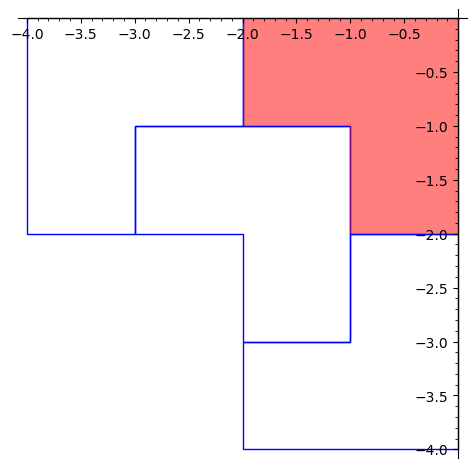

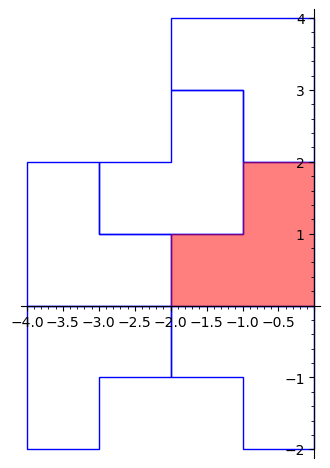

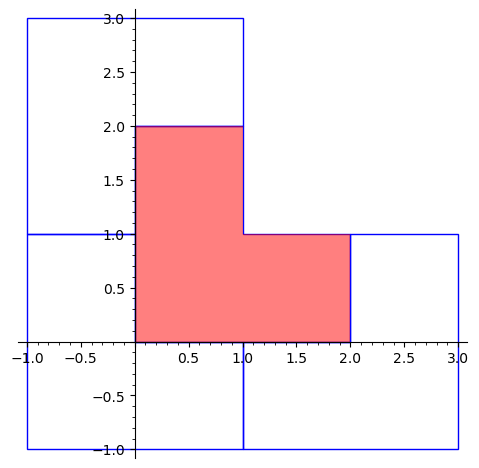

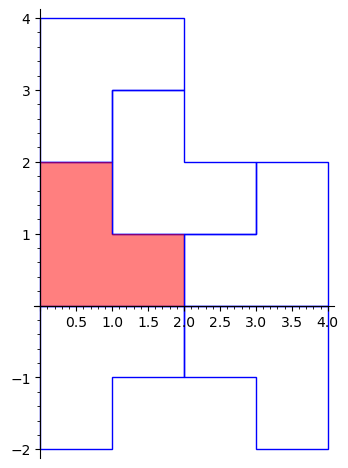

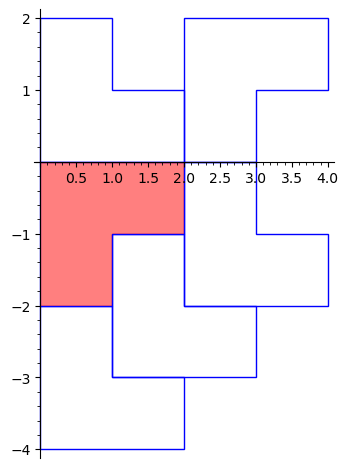

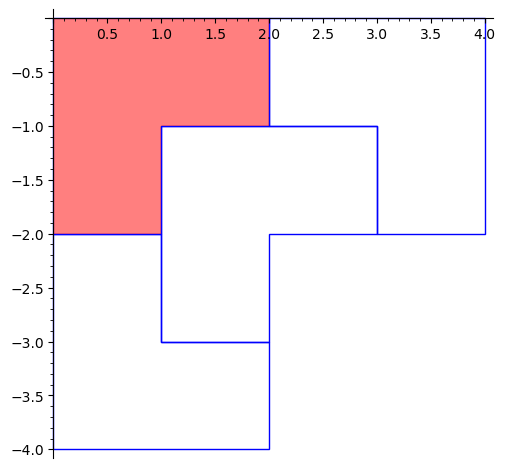

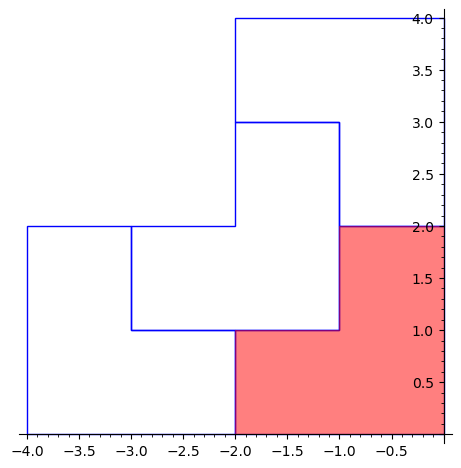

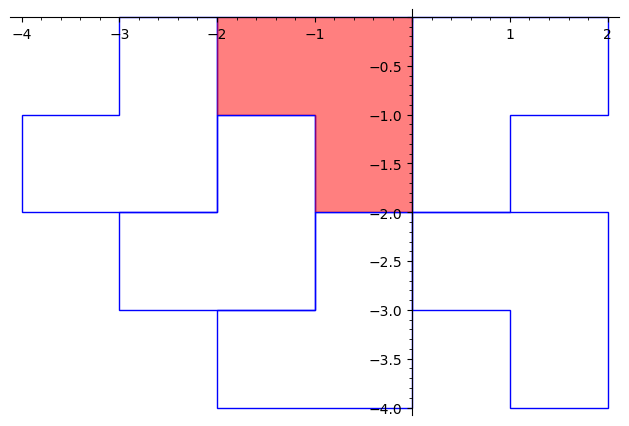

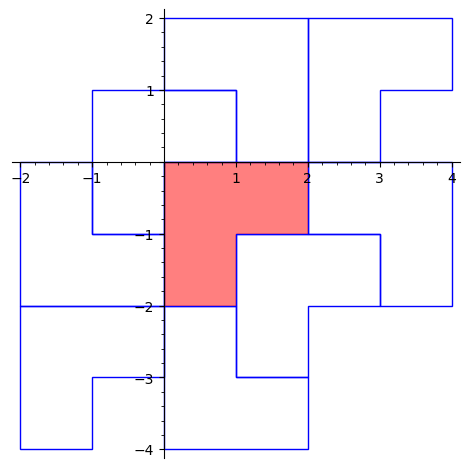

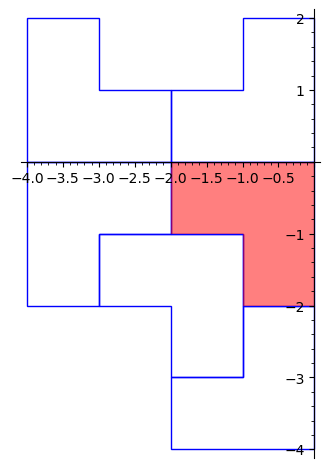

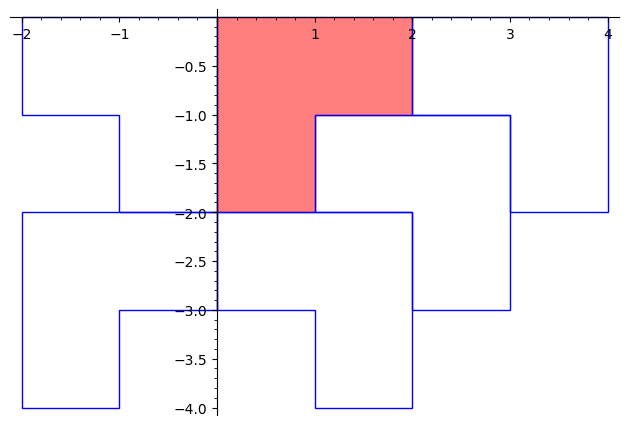

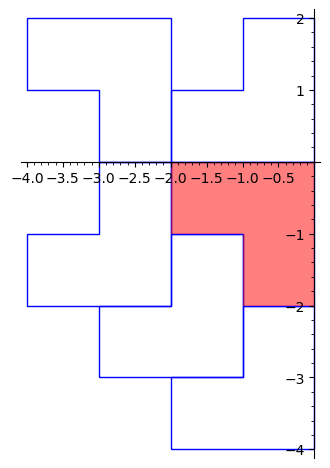

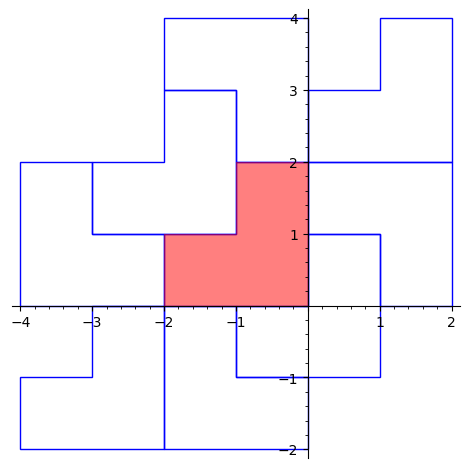

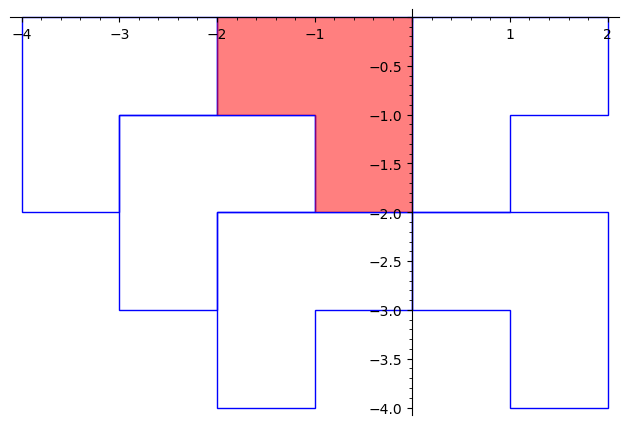

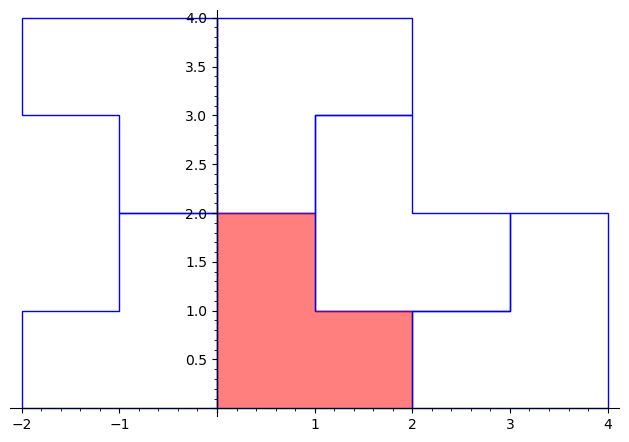

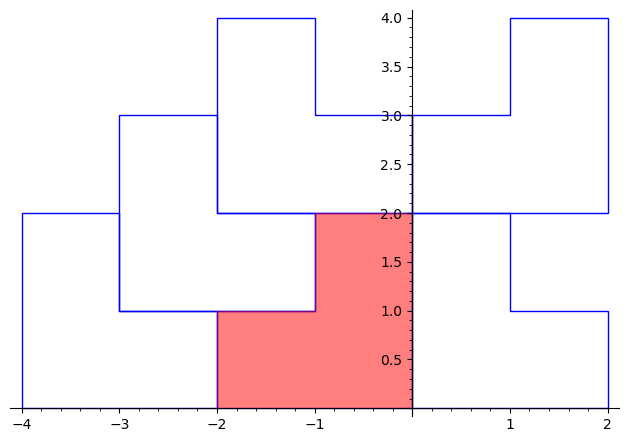

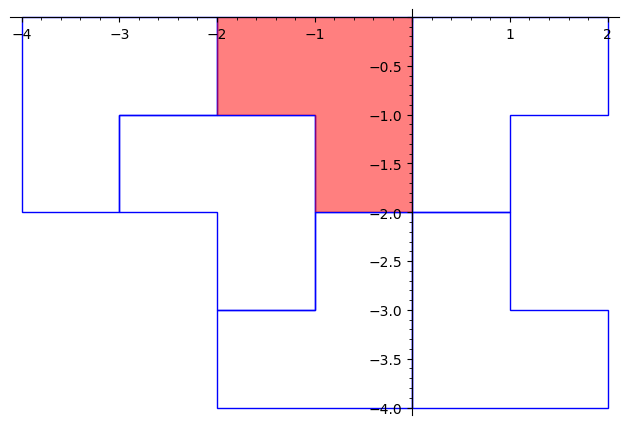

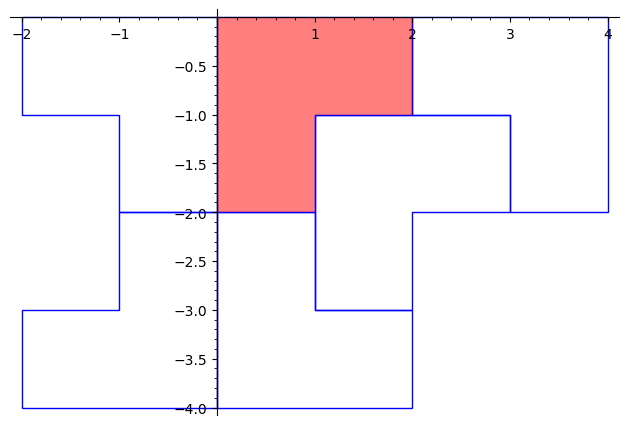

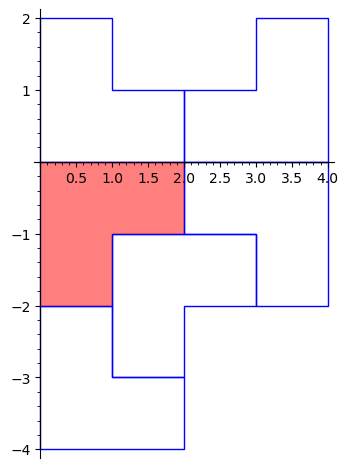

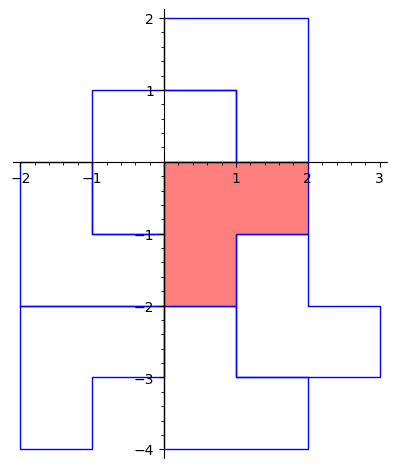

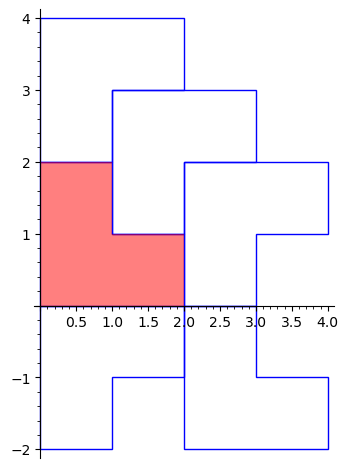

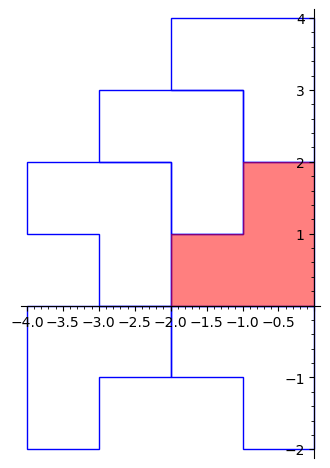

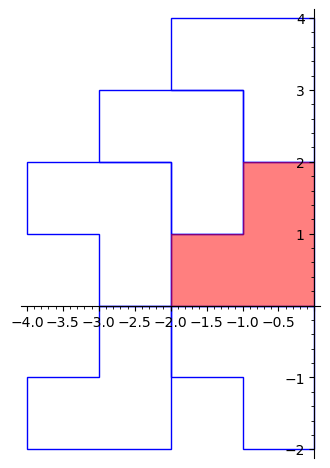

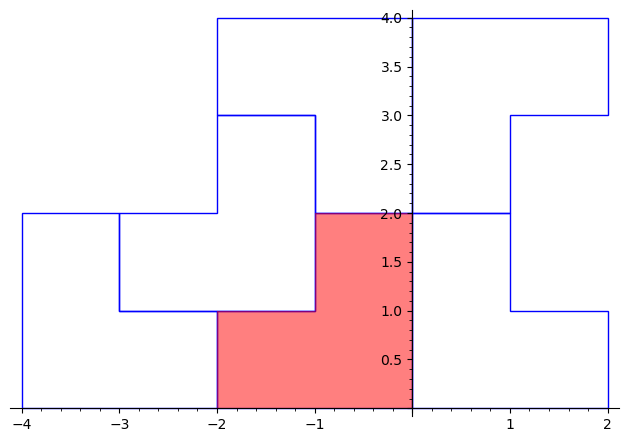

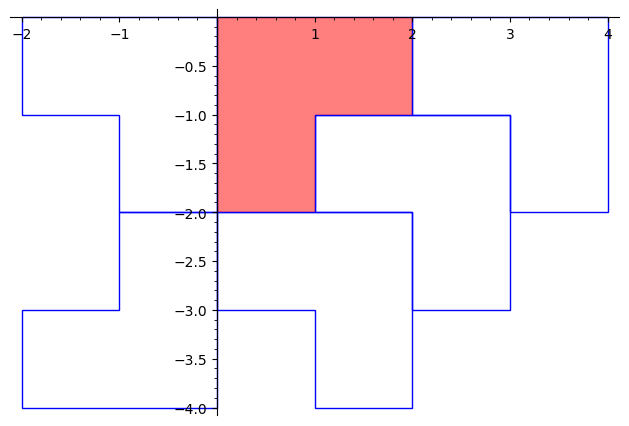

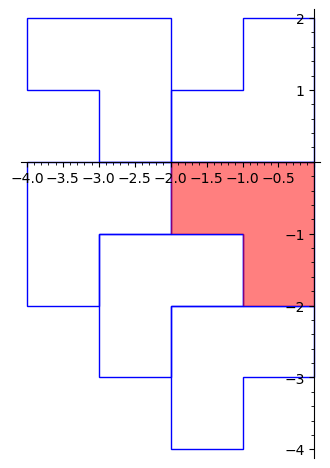

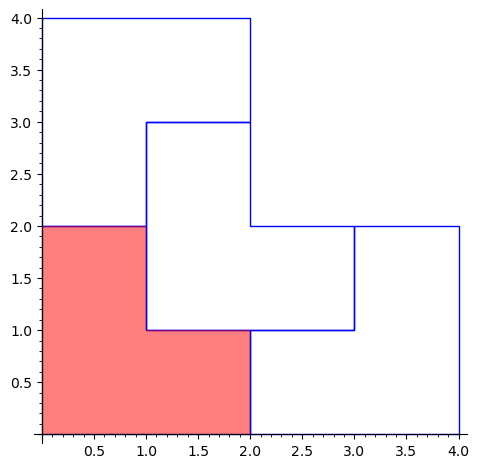

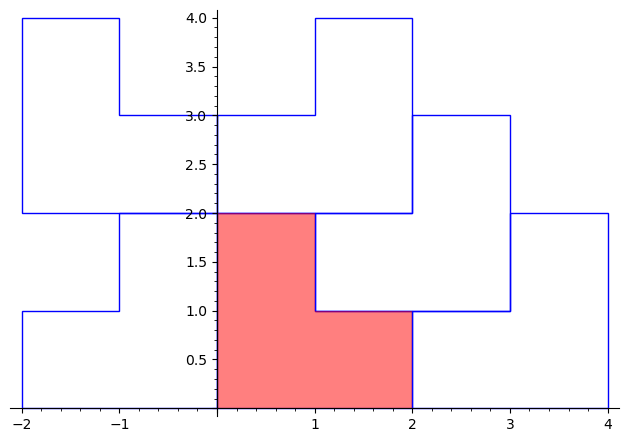

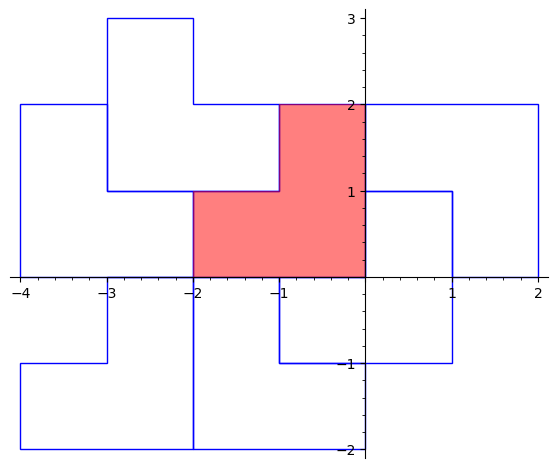

In [77]:
difference = collars - collars_found
for patch in difference:
    patch.display_patch(patch.parent)

In [8]:
# We want to form a list of 1-collars for the chair tile. We can use symmetry and the boundary
# trick to do this until we find the known limit of 56 1-collars. Specifically, we want to
# generate larger and larger supertiles and find which new collars appear on the boundary 
# between the old supertile and the new one. Then, we find the neighbors of those tiles, and 
# add them to a set of all 1-collars, until we find 56.

# A patch represents a group of tiles. Specifically, we want one to represent a group of tiles
# which are all neighboring, and which form a k-collar of the central tile. 
class Patch:
    def __init__ (self):
        self.tiles = set()
        self.parent = None
        self.hash = set()

    # Add a tile to this patch. If the patch does not yet have any tiles in it,
    # then mark its parent as the first tile added. Tiles in a patch are given as
    # lists of points relative to the parent tile, so two patches that are the same
    # up to translation are equivalent as Patch objects.
    def add_tile(self, tile):
        if self.parent == None:
            self.parent = tile

        # Maintain a list of certain values to use to hash a Patch object. Specifically,
        # we want patches to have the same hash if they have the same prototiles arranged
        # in the same way. This seems to work for now but might need tweaking in the future.
        # self.hash.add(tile.orientation)
        for p in tile.points:
            self.hash.add((tile.orientation, p[0] - self.parent.origin[0], p[1] - self.parent.origin[1]))

        tile_pts_relative = tuple((vector((p[0] - self.parent.origin[0], p[1] - self.parent.origin[1]), immutable=True) for p in tile.points))
        self.tiles.add(tile_pts_relative)

    # Displays the patch graphically, with tile marked in red.
    def display_patch (self, tile=None):
        G = Graphics()
        for t in self.tiles:
            G += polygon(t, fill=false, axes=False)

        if tile != None:
            highlight_points = [vector((p[0] - self.parent.origin[0], p[1] - self.parent.origin[1])) for p in tile.points]
            G += polygon(highlight_points, fill=true, rgbcolor=(1,0,0), alpha=0.5, axes=False)
                
        return G

    def display_patch_no_highlight (self):
        G = Graphics()
        for t in self.tiles:
            G += polygon(t, fill=false)

        show(G)

    # Compares two patches. Specifically, this returns True if both patches have the
    # same tiles in the same relative positions. So two patches are equal if one is 
    # a translation of the other to somewhere else in the plane. 
    def __eq__ (self, other):
        if type(self) != type(other):
            return False

        # This is probably bad style, but works for now. TODO: make this more explicit
        return self.__hash__() == other.__hash__()
    
    # See add_tile for details. Two patches should have the same hash if they contain the
    # same pattern of prototiles. To enforce this, we keep a set (which we cast to frozenset
    # to hash) which contains the orientations and origins of each prototile in the patch. 
    # Something to consider: can two patches have the same number of different origins/orientations
    # and not be equal, i.e. not have the same pattern? I don't know.
    def __hash__ (self):
        # Definitely bad style, but this is fine as long as we don't change a patch object after hashing.
        return hash(frozenset(self.hash))

# TODO: Represent supertiles as graphs, where prototiles are vertices and edges are neighbor relationships
# Then, we can find neighbors-of-neighbors by squaring the adjacency matrix.
# To identify interior vertices, look for endpoints of edges that are only connected to one prototile

# Finds the neighbors of the prototile p_tiles, out of the prototiles present in s_tile.
# Returns a list of prototiles that represents the neigbors of each p_tile. We just use vert_map
# to find all prototiles that share a vertex with p_tile.
def find_neighbors(s_tile: ChairTile, p_tile):
    neighborhood = set()
    for p in p_tile.points:
        for t in s_tile.vert_map[p]:
            neighborhood.add(t)

    return neighborhood

# Same as find_neighbors, but uses an adjacency matrix to find the neighbors. This is much faster,
# and we can also quickly find the k-neighborhood instead of just the 1-neighborhood. 
def find_k_neighbors(s_tile, p_tile, k):
    neighborhood = set()
    mat = Matrix(s_tile.adj)^k
    for t in range(len(s_tile.adj)):
        if mat[p_tile.id, t] >= 1 and p_tile.id != t:
            neighborhood.add(s_tile.prototile_ids[t])

    return neighborhood